# NIRCam PSF-matched multiband photometry

Analyzing real JWST data!

NIRCam images in 8 filters
0.06" / pixel image reductions (native SW ~0.03", LW ~0.06")  

Photutils 1.5 photometry  
PSF-matched using WebbPSF models  
F200W blurred to match PSF of each long wavelength image  
Colors measured in isophotal apertures  
Fluxes corrected to total in Kron apertures  
Flux uncertainties corrected for correlated pixel noise  

Detection image is weighted stack of all filters  
I find this performs better than a single filter F200W detection image:
* deeper (mag ~30 instead of ~29)
* larger apertures to capture more flux in LW images and measure more accurate colors
* fills the SW gaps (not filled by dithers in this program)

This is an updated version of an older JWST Data Analysis [JDAT notebook](https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam_PSF-matched_photometry/NIRCam_PSF_matched_multiband_photometry.html) 
that analyzed JADES JAGUAR simulated images

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

import photutils
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog#, source_properties
from photutils.utils import calc_total_error
print('photutils', photutils.__version__)
from packaging import version
if version.parse(photutils.__version__) < version.parse("1.4.0"):
    print('WARNING photutils not up to date with 1.4: convolution may take forever; also need to tweak error input command below')

from photutils.psf.matching import resize_psf, create_matching_kernel, CosineBellWindow
from astropy.convolution import convolve, convolve_fft # , Gaussian2DKernel, Tophat2DKernel

from scipy import ndimage

photutils 1.5.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

# Import images

In [4]:
def extract_filter(image_file):
    #return image_file.split('_')[0].lower().split('-')[1]
    return image_file.split('_')[-2].lower().split('-')[1]

In [5]:
image_directory = '../images/pipeline/'
image_files_list = glob(os.path.join(image_directory, '*_i2d.fits*'))
#image_files_list = glob('../images/pipeline/*_sci.fits*')
image_files_list = list(np.sort(image_files_list))
#filters = [image_file.split('_')[-2] for image_file in image_files_list]
filters = list(map(extract_filter, image_files_list))

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns

#filters
image_files = {}
for i, filt in enumerate(filters):
    image_files[filt] = image_files_list[i]
    print(filt, image_files[filt])

f090w ../images/pipeline/jw02282-o010_t001_nircam_clear-f090w_i2d.fits
f115w ../images/pipeline/jw02282-o010_t001_nircam_clear-f115w_i2d.fits
f150w ../images/pipeline/jw02282-o010_t001_nircam_clear-f150w_i2d.fits
f200w ../images/pipeline/jw02282-o010_t001_nircam_clear-f200w_i2d.fits
f277w ../images/pipeline/jw02282-o010_t001_nircam_clear-f277w_i2d.fits
f356w ../images/pipeline/jw02282-o010_t001_nircam_clear-f356w_i2d.fits
f410m ../images/pipeline/jw02282-o010_t001_nircam_clear-f410m_i2d.fits
f444w ../images/pipeline/jw02282-o010_t001_nircam_clear-f444w_i2d.fits


In [6]:
field = os.path.basename(image_files[filt]).split('_')[0]
field = 'whl0137'
field

'whl0137'

# Align images if needed

In [7]:
from reproject import reproject_interp  # https://reproject.readthedocs.io/en/stable/

In [9]:
idata = 'sci'        # extension of HDU where data lives
idata_error = 'err'  # extension of HDU where data_error lives
idata_weight = 'wht' # extension of HDU where data_weight lives

In [20]:
reference_filter = 'f200w'  # all images will be pixel aligned to this filter you choose
reference_file = image_files[reference_filter]
reference_hdu = fits.open(reference_file)
reference_header = reference_hdu[idata].header[:] # Use SCIence header for every output header

reference_file

'../images/pipeline/jw02282-o010_t001_nircam_clear-f200w_i2d.fits'

In [21]:
imwcs = wcs.WCS(reference_hdu[idata].header, reference_hdu)
imwcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.34693061771644  -8.433366759292145  
CRPIX : 4995.85969078796  2278.933430465513  
PC1_1 PC1_2  : 0.3039254602899507  -0.9526958143014703  
PC2_1 PC2_2  : -0.9526958143014703  -0.3039254602899507  
CDELT : 8.67540915910755e-06  8.67540915910755e-06  
NAXIS : 10076  4581

In [22]:
data = reference_hdu[idata].data[:]

In [23]:
imwcs = wcs.WCS(reference_hdu[idata].header, reference_hdu)
ny, nx = data.shape
# image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
outline = filt.ljust(6)
outline += ' %5d x %5d pixels' % (ny, nx)
outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
outline += ' (%.2f" / pixel)' % image_pixel_scale
print(outline)    

f444w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)


In [27]:
filt = 'f444w'
extension = 'sci'
input_image = image_files[filt]
hdu_list = fits.open(input_image)

output_image = '%s_%s_%s_%s.fits' % (field, 'nircam', filt, extension)
output_image = os.path.join(image_directory, output_image)
if os.path.exists(output_image):
    print(output_image, 'EXISTS')
else:
    hdu = hdu_list[extension]
    output_header = reference_header[:]
    output_header['EXTNAME'] = extension
    if filt == reference_filter:
        print('SAVING', output_image)
        fits.writeto(output_image, hdu.data, output_header)
    else:
        print('Reprojecting %s %s to %s (will take a minute)...' % (filt, extension, reference_filter))
        #hdu.header = output_header
        reprojected_data, footprint = reproject_interp(hdu, reference_header)
        wavelength = int(filt[1:4]) / 100
        if wavelength > 2.4:
            print('shifting data a pixel left & a pixel down')
            reprojected_data = np.roll(reprojected_data, (-1, -1), axis=(1, 0))  # +right, +up
        print('SAVING', output_image)
        fits.writeto(output_image, reprojected_data, output_header)

Reprojecting f444w sci to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f444w_sci.fits


In [30]:
for i, filt in enumerate(filters):
    input_image = image_files[filt]
    hdu_list = fits.open(input_image)
    # Use SCIence header for every output header
    #reference_header = hdu_list['sci'].header[:]

    for extension in 'sci err wht'.split():
        #output_image = input_image.replace('_i2d.fits', '_%s.fits' % extension)
        output_image = '%s_%s_%s_%s.fits' % (field, 'nircam', filt, extension)
        output_image = os.path.join(image_directory, output_image)
        if os.path.exists(output_image):
            print(output_image, 'EXISTS')
        else:
            hdu = hdu_list[extension]
            hdu.header = hdu_list[idata].header  # Put WCS into header
            output_header = reference_header[:]
            output_header['EXTNAME'] = extension
            if filt == reference_filter:
                print('SAVING', output_image)
                fits.writeto(output_image, hdu.data, output_header)
            else:
                print('Reprojecting %s %s to %s (will take a minute)...' % (filt, extension, reference_filter))
                #hdu.header = output_header
                reprojected_data, footprint = reproject_interp(hdu, reference_header)
                #wavelength = int(filt[1:4]) / 100
                if wavelengths[i] > 2.4 * u.um:  
                    print('shifting data a pixel left & a pixel down')
                    reprojected_data = np.roll(reprojected_data, (-1, -1), axis=(1, 0))  # +right, +up
                print('SAVING', output_image)
                fits.writeto(output_image, reprojected_data, output_header)

../images/pipeline/whl0137_nircam_f090w_sci.fits EXISTS
Reprojecting f090w err to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f090w_err.fits
Reprojecting f090w wht to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f090w_wht.fits
Reprojecting f115w sci to f200w (will take a minute)...


Set DATE-AVG to '2022-07-30T16:07:49.292' from MJD-AVG.
Set DATE-END to '2022-07-30T16:27:35.743' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.047454 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704950456.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


SAVING ../images/pipeline/whl0137_nircam_f115w_sci.fits
Reprojecting f115w err to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f115w_err.fits
Reprojecting f115w wht to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f115w_wht.fits
Reprojecting f150w sci to f200w (will take a minute)...


Set DATE-AVG to '2022-07-30T16:51:39.808' from MJD-AVG.
Set DATE-END to '2022-07-30T17:11:26.268' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.038334 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704871110.602 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


SAVING ../images/pipeline/whl0137_nircam_f150w_sci.fits
Reprojecting f150w err to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f150w_err.fits
Reprojecting f150w wht to f200w (will take a minute)...
SAVING ../images/pipeline/whl0137_nircam_f150w_wht.fits
../images/pipeline/whl0137_nircam_f200w_sci.fits EXISTS
../images/pipeline/whl0137_nircam_f200w_err.fits EXISTS
../images/pipeline/whl0137_nircam_f200w_wht.fits EXISTS
Reprojecting f277w sci to f200w (will take a minute)...


Set DATE-AVG to '2022-07-30T17:35:35.687' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]


shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f277w_sci.fits
Reprojecting f277w err to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f277w_err.fits
Reprojecting f277w wht to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f277w_wht.fits
Reprojecting f356w sci to f200w (will take a minute)...


Set DATE-AVG to '2022-07-30T16:51:39.794' from MJD-AVG.
Set DATE-END to '2022-07-30T17:11:26.204' from MJD-END'. [astropy.wcs.wcs]


shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f356w_sci.fits
Reprojecting f356w err to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f356w_err.fits
Reprojecting f356w wht to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f356w_wht.fits
Reprojecting f410m sci to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f410m_sci.fits
Reprojecting f410m err to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f410m_err.fits
Reprojecting f410m wht to f200w (will take a minute)...
shifting data a pixel left & a pixel down
SAVING ../images/pipeline/whl0137_nircam_f410m_wht.fits
../images/pipeline/whl0137_nircam_f444w_sci.fits EXISTS
Reprojecting f444w err to f200w (will take a minute)...
shifting data a pixe

# Image extensions

In [31]:
def extract_filter(image_file):
    return image_file.split('_')[-2].lower()#.split('-')[1]
    #return image_file.split('_')[-2].lower().split('-')[1]

In [32]:
image_directory = '../images/pipeline/'
image_files_list = glob(os.path.join(image_directory, '*_sci.fits*'))
#image_files_list = glob('../images/pipeline/*_sci.fits*')
image_files_list = list(np.sort(image_files_list))
#filters = [image_file.split('_')[-2] for image_file in image_files_list]
filters = list(map(extract_filter, image_files_list))
#print(filters)

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])
#wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns

#filters
image_files = {}
for i, filt in enumerate(filters):
    image_files[filt] = image_files_list[i]
    print(filt, image_files[filt])

f090w ../images/pipeline/whl0137_nircam_f090w_sci.fits
f115w ../images/pipeline/whl0137_nircam_f115w_sci.fits
f150w ../images/pipeline/whl0137_nircam_f150w_sci.fits
f200w ../images/pipeline/whl0137_nircam_f200w_sci.fits
f277w ../images/pipeline/whl0137_nircam_f277w_sci.fits
f356w ../images/pipeline/whl0137_nircam_f356w_sci.fits
f410m ../images/pipeline/whl0137_nircam_f410m_sci.fits
f444w ../images/pipeline/whl0137_nircam_f444w_sci.fits


In [33]:
# Check size of every image; they need to be the same, all pixel aligned
# Load data

image_data_dict = {}

for filt in filters:
    infile = image_files[filt]
    hdu = fits.open(infile)
    data = hdu[idata].data
    #data = fill_stars(data)
    image_data_dict[filt] = data
    
    imwcs = wcs.WCS(hdu[idata].header, hdu)
    ny, nx = data.shape
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = filt.ljust(6)
    outline += ' %5d x %5d pixels' % (ny, nx)
    outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)    

f090w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f115w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f150w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f200w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f277w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f356w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f410m   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)
f444w   4581 x 10076 pixels = 143.07" x 314.69" (0.03" / pixel)


In [34]:
# Data Error arrays
data_error_files = {}
for filt in filters:
    #data_error_files[filt] = image_files[filt].replace('_sci.fits', '_err.fits')
    extension = 'err'
    output_image = '%s_%s_%s_%s.fits' % (field, 'nircam', filt, extension)
    output_image = os.path.join(image_directory, output_image)
    data_error_files[filt] = output_image
    print(filt, data_error_files[filt])

f090w ../images/pipeline/whl0137_nircam_f090w_err.fits
f115w ../images/pipeline/whl0137_nircam_f115w_err.fits
f150w ../images/pipeline/whl0137_nircam_f150w_err.fits
f200w ../images/pipeline/whl0137_nircam_f200w_err.fits
f277w ../images/pipeline/whl0137_nircam_f277w_err.fits
f356w ../images/pipeline/whl0137_nircam_f356w_err.fits
f410m ../images/pipeline/whl0137_nircam_f410m_err.fits
f444w ../images/pipeline/whl0137_nircam_f444w_err.fits


In [35]:
# Weight arrays
weight_files = {}
for filt in filters:
    #weight_files[filt] = image_files[filt].replace('_sci.fits', '_wht.fits')
    extension = 'wht'
    output_image = '%s_%s_%s_%s.fits' % (field, 'nircam', filt, extension)
    output_image = os.path.join(image_directory, output_image)
    weight_files[filt] = output_image
    print(filt, weight_files[filt])

f090w ../images/pipeline/whl0137_nircam_f090w_wht.fits
f115w ../images/pipeline/whl0137_nircam_f115w_wht.fits
f150w ../images/pipeline/whl0137_nircam_f150w_wht.fits
f200w ../images/pipeline/whl0137_nircam_f200w_wht.fits
f277w ../images/pipeline/whl0137_nircam_f277w_wht.fits
f356w ../images/pipeline/whl0137_nircam_f356w_wht.fits
f410m ../images/pipeline/whl0137_nircam_f410m_wht.fits
f444w ../images/pipeline/whl0137_nircam_f444w_wht.fits


In [37]:
idata = 'sci'        # extension of HDU where data lives
idata_error = 'err'  # extension of HDU where data_error lives
idata_weight = 'wht' # extension of HDU where data_weight lives

In [36]:
idata = 1        # extension of HDU where data lives
idata_error = 2  # extension of HDU where data_error lives
idata_weight = 3 # extension of HDU where data_weight lives

In [ ]:
idata = 0        # extension of HDU where data lives
idata_error = 0  # extension of HDU where data_error lives
idata_weight = 0 # extension of HDU where data_weight lives

## Load one image: F200W

In [38]:
#detection_filter = 
filt = 'F200W'.lower()
infile = image_files[filt]
hdu = fits.open(infile)
data = hdu[idata].data
imwcs = wcs.WCS(hdu[idata].header, hdu)
data_error = fits.open(data_error_files[filt])[idata_error].data

## Report image size and field of view

In [39]:
ny, nx = data.shape
# image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * image_pixel_scale, nx * image_pixel_scale)
outline += ' (%.2f" / pixel)' % image_pixel_scale
print(outline)

4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


# View images (optional)

<IPython.core.display.Javascript object>


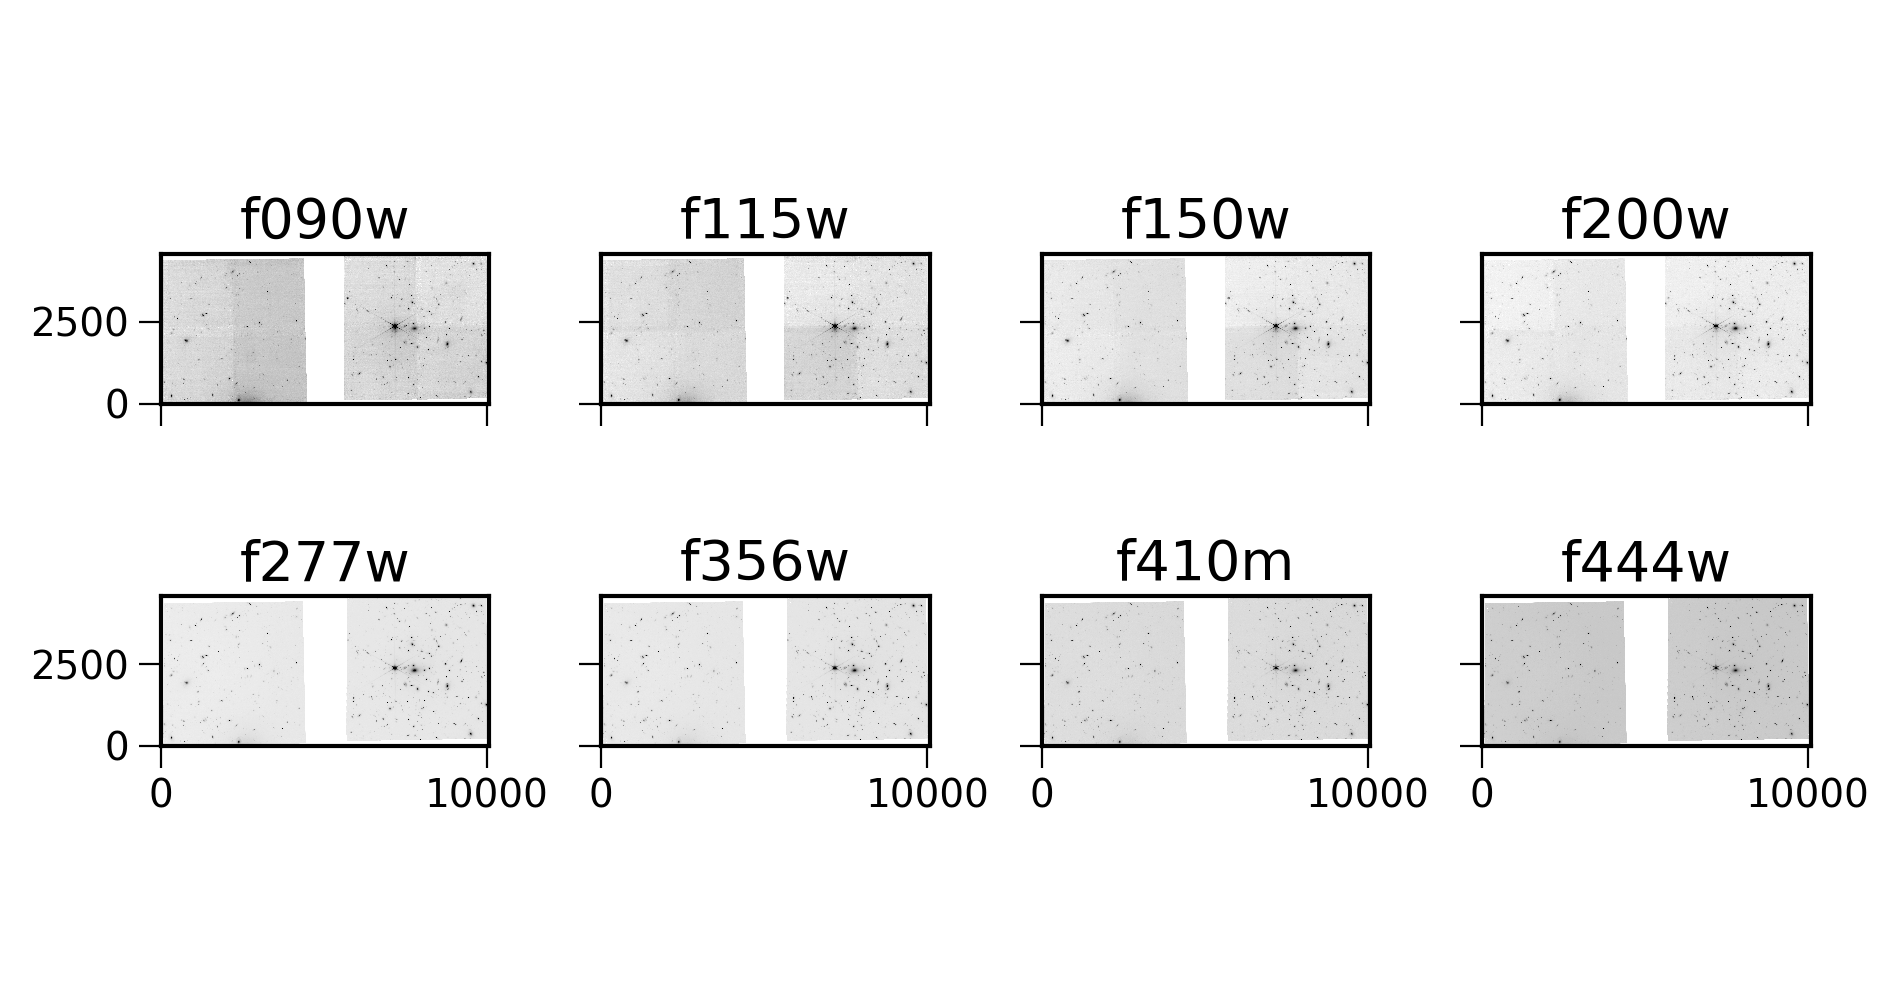

In [40]:
nrows = 2
ncolumns = int(np.ceil(len(filters) / nrows))
fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,5), sharex=True, sharey=True)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
for i, filt in enumerate(filters):
    iy = i // ncolumns
    ix = i %  ncolumns
    hdu = fits.open(image_files_list[i])
    data = hdu[idata].data
    data = np.where(data, data, np.nan)  # ignore blank areas when scaling
    norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
    ax[iy,ix].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys')
    ax[iy,ix].set_title(filt)

# Weighted sum detection image

In [41]:
# preserve nan if a & b are both nan; otherwise treat nan as 0
def nan_sum(a, b):
    return np.where(np.isnan(a), b, np.where(np.isnan(b), a, a+b))

In [42]:
# Load / create weighted sum image

image_files['total']      = image_files[filt].replace(filt, 'total')
weight_files['total']     = weight_files[filt].replace(filt, 'total')
data_error_files['total'] = data_error_files[filt].replace(filt, 'total')
# error = RMS = sqrt(VAR)

if os.path.exists(image_files['total']):
    print('Loading', image_files['total'])
    data_total   = fits.open(image_files['total'])[idata].data
    print('Loading', weight_files['total'])
    weight_total = fits.open(weight_files['total'])[idata_weight].data
    print('Loading', data_error_files['total'])
    error_total  = fits.open(data_error_files['total'])[idata_error].data
else:
    print('Create weighted sum detection image...')
    data_weighted_sum = 0
    weight_total = 0
    error_squared_weighted_sum = 0
    for filt in filters:
        print(filt)
        data   = fits.open(image_files[filt])[idata].data
        weight = fits.open(weight_files[filt])[idata_weight].data
        data_error = fits.open(data_error_files[filt])[idata_error].data
        
        # Set nan to 0
        data   = np.where(np.isnan(data), 0, data)
        weight = np.where(np.isnan(weight), 0, weight)        
        data_error = np.where(np.isnan(data_error), 0, data_error)
        # preserve nan's in data_error: shows where there's no data and defines edge of image below
        
        data_weighted_sum = data_weighted_sum + weight * data
        weight_total = weight_total + weight
        
        # error_squared_weighted_sum = error_squared_weighted_sum + (weight * data_error) ** 2
        error_squared_weighted_sum = nan_sum(error_squared_weighted_sum, (weight * data_error) ** 2)

    data_total = np.where(weight_total, data_weighted_sum / weight_total, np.nan)
    error_total = np.sqrt(error_squared_weighted_sum) / weight_total
    
    # Save weighted sum image
    hdu = fits.open(image_files[filt])
    hdu[idata].data = data_total
    print('Saving', image_files['total'])
    hdu.writeto(image_files['total'])
    
    # Save weight sum
    hdu = fits.open(weight_files[filt])
    hdu[idata_weight].data = weight_total
    print('Saving', weight_files['total'])
    hdu.writeto(weight_files['total'])    
    
    # Save data error sum
    hdu = fits.open(data_error_files[filt])
    hdu[idata_error].data = error_total
    print('Saving', data_error_files['total'])
    hdu.writeto(data_error_files['total'])    

Create weighted sum detection image...
f090w
f115w
f150w
f200w
f277w
f356w
f410m
f444w


/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_2770/2222482740.py:38: RuntimeWarning: invalid value encountered in divide
  data_total = np.where(weight_total, data_weighted_sum / weight_total, np.nan)
/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_2770/2222482740.py:39: RuntimeWarning: invalid value encountered in divide
  error_total = np.sqrt(error_squared_weighted_sum) / weight_total


Saving ../images/pipeline/whl0137_nircam_total_sci.fits
Saving ../images/pipeline/whl0137_nircam_total_wht.fits
Saving ../images/pipeline/whl0137_nircam_total_err.fits


## View total Data, Weight, Error (optional)

<IPython.core.display.Javascript object>


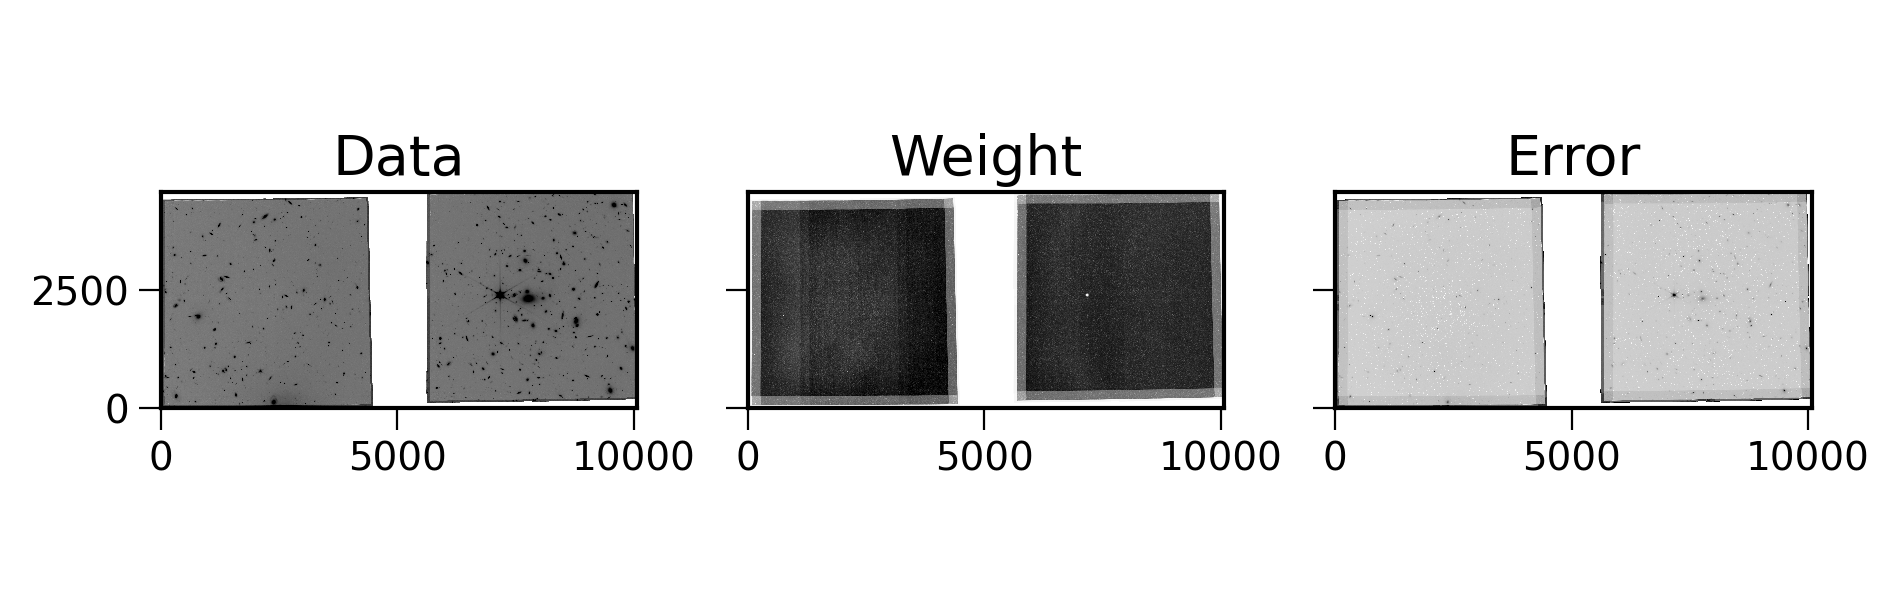

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(9.5, 3), sharex=True, sharey=True)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
ax[0].set_title('Data')
ax[0].imshow(data_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

ax[1].set_title('Weight')
norm = simple_norm(weight_total, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[1].imshow(weight_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

ax[2].set_title('Error')
norm = simple_norm(error_total, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[2].imshow(error_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

## Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

JWST data units: MJy / sr  
Mega Janskys (MJy); mag_AB = 8.9 - 2.5 log10(flux_Jy) = 31.4 - 2.5 log10(flux_nJy)  
steradian (sr) is a unit of solid angle: sphere = 4 pi sr = 4 pi (180 deg / pi)^2 = 41253 deg^2 = 2.2e16 arcsec^2

In [44]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

Note magnitude uncertainties for detections should probably be u.mag instead of u.ABmag  
but magnitude uncertainties for non-detections quote u.ABmag upper limits  
They need to be the same, so we go with u.ABmag  

## Detect Sources and Deblend using astropy.photutils (similar to SourceExtractor)
https://photutils.readthedocs.io/en/latest/segmentation.html

In [45]:
# Define all detection and measurement parameters here so that we do measurements consistently for every image

JWST_flux_units = u.MJy / u.sr

# https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceCatalog.html#photutils.segmentation.SourceCatalog.area
output_properties = 'label xcentroid ycentroid sky_centroid area semimajor_sigma semiminor_sigma'.split()
output_properties += 'fwhm ellipticity orientation gini'.split()
output_properties += 'kron_radius local_background segment_flux segment_fluxerr kron_flux kron_fluxerr'.split()
# columns += 'source_sum source_sum_err kron_flux kron_fluxerr kron_radius local_background'.split()

class Photutils_Catalog:
    def __init__(self, filt, image_file=None, error_file=None, verbose=True, mask_edge_thickness=10):
        self.image_file = image_file or image_files[filt]
        self.hdu = fits.open(self.image_file)
        self.imwcs = wcs.WCS(self.hdu[idata].header, self.hdu)
        self.data       = self.hdu[idata].data  # 'SCI' i2d extension 1
        self.convolved_data = None  # initialize; to be populated later; added in photutils 1.4

        # total error array (i.e., the background-only error plus Poisson noise due to individual sources)
        # https://photutils.readthedocs.io/en/stable/segmentation.html#photometric-errors        
        #self.data_error = self.hdu[2].data  # 'ERR' i2d extension 2
        self.data_error_file = error_file or data_error_files[filt]
        self.data_error = fits.open(self.data_error_file)[idata_error].data
        self.data_mask = np.isnan(self.data_error) # | (model.wht == 0)
        # Remove edge detections: Grow the mask by 10 pixels
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html
        self.data_mask = ndimage.binary_dilation(self.data_mask, iterations=mask_edge_thickness)

        # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
        self.pixel_scale = wcs.utils.proj_plane_pixel_scales(self.imwcs)[0] 
        self.pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
        self.flux_units = JWST_flux_units * (self.pixel_scale * u.arcsec)**2
        #self.zeropoint = self.hdu[0].header['ABMAG'] * u.ABmag 
        #self.zeropoint = 31.4 * u.ABmag # no zeropoint (ABMAG) in the header, add manually, 31.4 for nJy
        if verbose:
            print(self.image_file)
            ny, nx = self.data.shape
            outline = '%d x %d pixels' % (ny, nx)
            outline += ' = %g" x %g"' % (ny * self.pixel_scale, nx * self.pixel_scale)
            outline += ' (%.2f" / pixel)' % self.pixel_scale
            print(outline)
            #print(filt, '  zeropoint =', self.zeropoint)
            #print(self.weight_file)

    def measure_background_map(self, bkg_size=50, filter_size=3, verbose=True):
        # Calculate sigma-clipped background in cells of 50x50 pixels, then median filter over 3x3 cells
        # For best results, the image should span an integer number of cells in both dimensions (e.g., 1000=20x50 pixels)
        # https://photutils.readthedocs.io/en/stable/background.html
        self.background_map = Background2D(self.data, bkg_size, filter_size=filter_size)

    def smooth_data(self, smooth_fwhm=2, kernel_size=5):
        # convolve data with Gaussian 
        # convolved_data used for source detection and to calculate source centroids and morphological properties
        smooth_sigma = smooth_fwhm * gaussian_fwhm_to_sigma
        self.smooth_kernel = Gaussian2DKernel(smooth_sigma, x_size=kernel_size, y_size=kernel_size)
        self.smooth_kernel.normalize()
        self.convolved_data = convolve(self.data, self.smooth_kernel)
        
    def run_detect_sources(self, nsigma, npixels, smooth_fwhm=2, kernel_size=5, 
                           deblend_levels=32, deblend_contrast=0.001, verbose=True):

        # Set detection threshold map as nsigma times RMS above background pedestal
        detection_threshold = (nsigma * self.background_map.background_rms) + self.background_map.background

        # Before detection, convolve data with Gaussian
        self.smooth_data(smooth_fwhm, kernel_size)

        # Detect sources with npixels connected pixels at/above threshold in data smoothed by kernel
        # https://photutils.readthedocs.io/en/stable/segmentation.html
        self.segm_detect = detect_sources(self.data, detection_threshold, npixels=npixels, kernel=self.smooth_kernel)

        # Deblend: separate connected/overlapping sources
        # https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending
        self.segm_deblend = deblend_sources(self.data, self.segm_detect, npixels=npixels, kernel=self.smooth_kernel,
                                            nlevels=deblend_levels, contrast=deblend_contrast)
        if verbose:
            output = 'Cataloged %d objects' % self.segm_deblend.nlabels
            output += ', deblended from %d detections' % self.segm_detect.nlabels
            median_threshold = (nsigma * self.background_map.background_rms_median) \
                + self.background_map.background_median
            output += ' with %d pixels above %g-sigma threshold' % (npixels, nsigma)
            # Background outputs equivalent to those reported by SourceExtractor
            output += '\n'
            output += 'Background median %g' % self.background_map.background_median
            output += ', RMS %g' % self.background_map.background_rms_median
            output += ', threshold median %g' % median_threshold
            print(output)

    def measure_source_properties(self, local_background_width=24, properties=output_properties):
        if version.parse(photutils.__version__) >= version.parse("1.4.0"):
            self.catalog = SourceCatalog(self.data-self.background_map.background, self.segm_deblend,
                                         convolved_data=self.convolved_data,  # photutils 1.4
                                         error=self.data_error, mask=self.data_mask,
                                         background=self.background_map.background, wcs=self.imwcs,
                                         localbkg_width=local_background_width)
        else:  # use filter_kernel instead of convolved_data
            self.catalog = SourceCatalog(self.data-self.background_map.background, self.segm_deblend, 
                                         kernel=self.smooth_kernel,  # photutils < 1.4 
                                         error=self.data_error, mask=self.data_mask,
                                         background=self.background_map.background, wcs=self.imwcs,
                                         localbkg_width=local_background_width)


        self.catalog_table = self.catalog.to_table(columns=properties)  # properties: quantities to keep
        
        # Convert fluxes to nJy units and to AB magnitudes
        for aperture in ['segment', 'kron']:
            if aperture+'_flux' in self.catalog_table.columns:
                flux    = self.catalog_table[aperture+'_flux']    * self.flux_units.to(u.nJy)
                fluxerr = self.catalog_table[aperture+'_fluxerr'] * self.flux_units.to(u.nJy)
                mag, magerr = fluxes2mags(flux, fluxerr)

                self.catalog_table[aperture+'_flux']    = flux
                self.catalog_table[aperture+'_fluxerr'] = fluxerr
                self.catalog_table[aperture+'_mag']     = mag
                self.catalog_table[aperture+'_magerr']  = magerr            

In [46]:
detection_filter = 'total'

In [47]:
detection_catalog = Photutils_Catalog(detection_filter)
detection_catalog.measure_background_map()
detection_catalog.run_detect_sources(nsigma=3, npixels=5)

../images/pipeline/whl0137_nircam_total_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/deblend.py:352: RuntimeWarning: All-NaN slice encountered
  self.source_min = np.nanmin(self.source_values)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/deblend.py:353: RuntimeWarning: All-NaN slice encountered
  self.source_max = np.nanmax(self.source_values)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/deblend.py:352: RuntimeWarning: All-NaN slice encountered
  self.source_min = np.nanmin(self.source_values)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/deblend.py:353: RuntimeWarning: All-NaN slice encountered
  self.source_max = np.nanmax(self.source_values)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/deblend.py:352: RuntimeWarning: All-NaN slice encountered
  self.source_min = np.nanmin(self.source_values)
/Users/dcoe/min

Cataloged 10614 objects, deblended from 8736 detections with 5 pixels above 3-sigma threshold
Background median 0.197836, RMS 0.0046181, threshold median 0.211691


In [48]:
# Remove masked segments (labels) at edges of image
# https://photutils.readthedocs.io/en/latest/api/photutils.segmentation.SegmentationImage.html#photutils.segmentation.SegmentationImage.remove_masked_labels
detection_catalog.segm_deblend.remove_masked_labels(detection_catalog.data_mask)

In [49]:
# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(detection_catalog.segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
outroot = field + '_' + detection_filter
segm_file = outroot+'_detections_segm.fits'
segm_hdu.writeto(segm_file, overwrite=True)
os.system('gzip ' + segm_file);  # they compress very nicely (mostly zeros)

In [50]:
detection_catalog.measure_source_properties()

/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [51]:
#detection_catalog.catalog_table  # show contents

In [52]:
# Tweak catalog
source_table = detection_catalog.catalog_table
source_table.rename_column('label', 'id')
source_table.rename_column('semimajor_sigma', 'a')
source_table.rename_column('semiminor_sigma', 'b')
source_table.rename_column('xcentroid', 'x')
source_table.rename_column('ycentroid', 'y')

# Replace sky_centroid with ra, dec
source_table['ra']  = source_table['sky_centroid'].ra.degree  * u.degree
source_table['dec'] = source_table['sky_centroid'].dec.degree * u.degree

columns = list(source_table.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

source_table = source_table[columns]

In [53]:
# If interested, view / save output, but photometry in other filters will be added soon!
if 1:
    source_table.write(outroot+'_detections.ecsv', overwrite=True)
    source_table.write(outroot+'_detections.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
    #source_table  # show contents
    outroot+'_detections.cat'

In [54]:
len(source_table)

10064

## Show detections

<IPython.core.display.Javascript object>


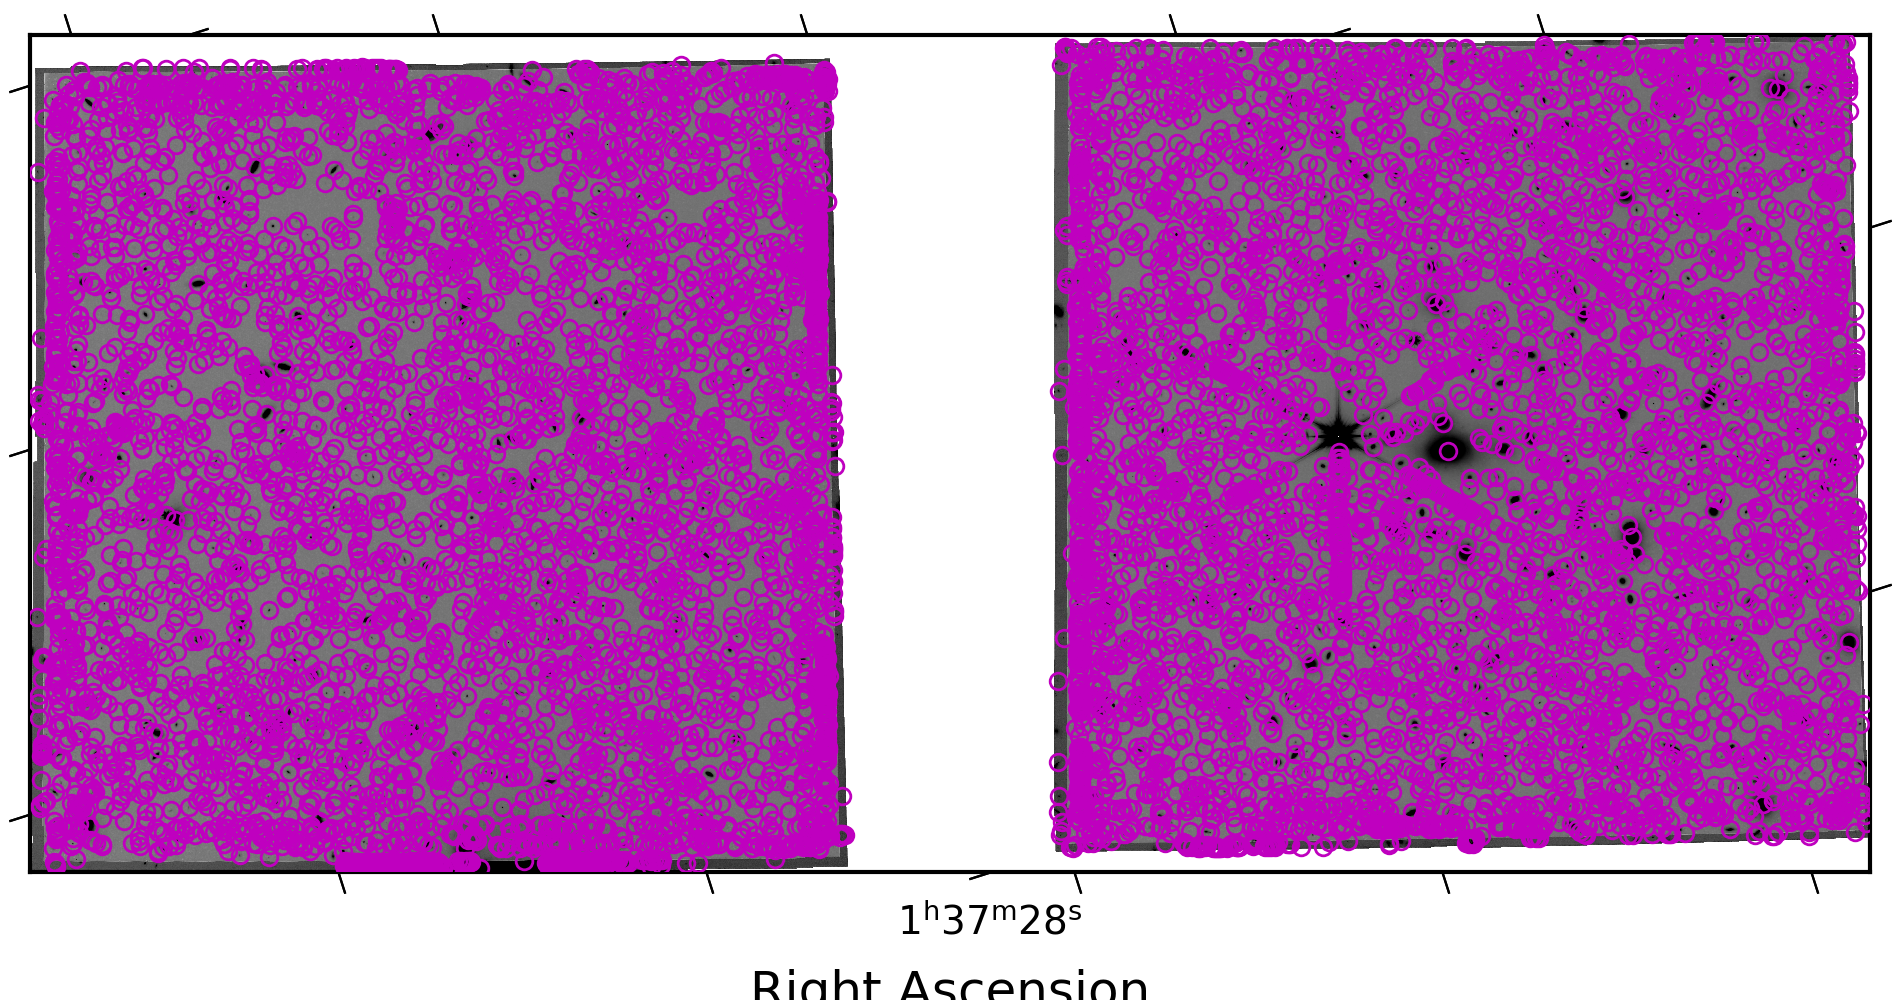

In [55]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(detection_catalog.data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(source_table['ra'], source_table['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

<IPython.core.display.Javascript object>


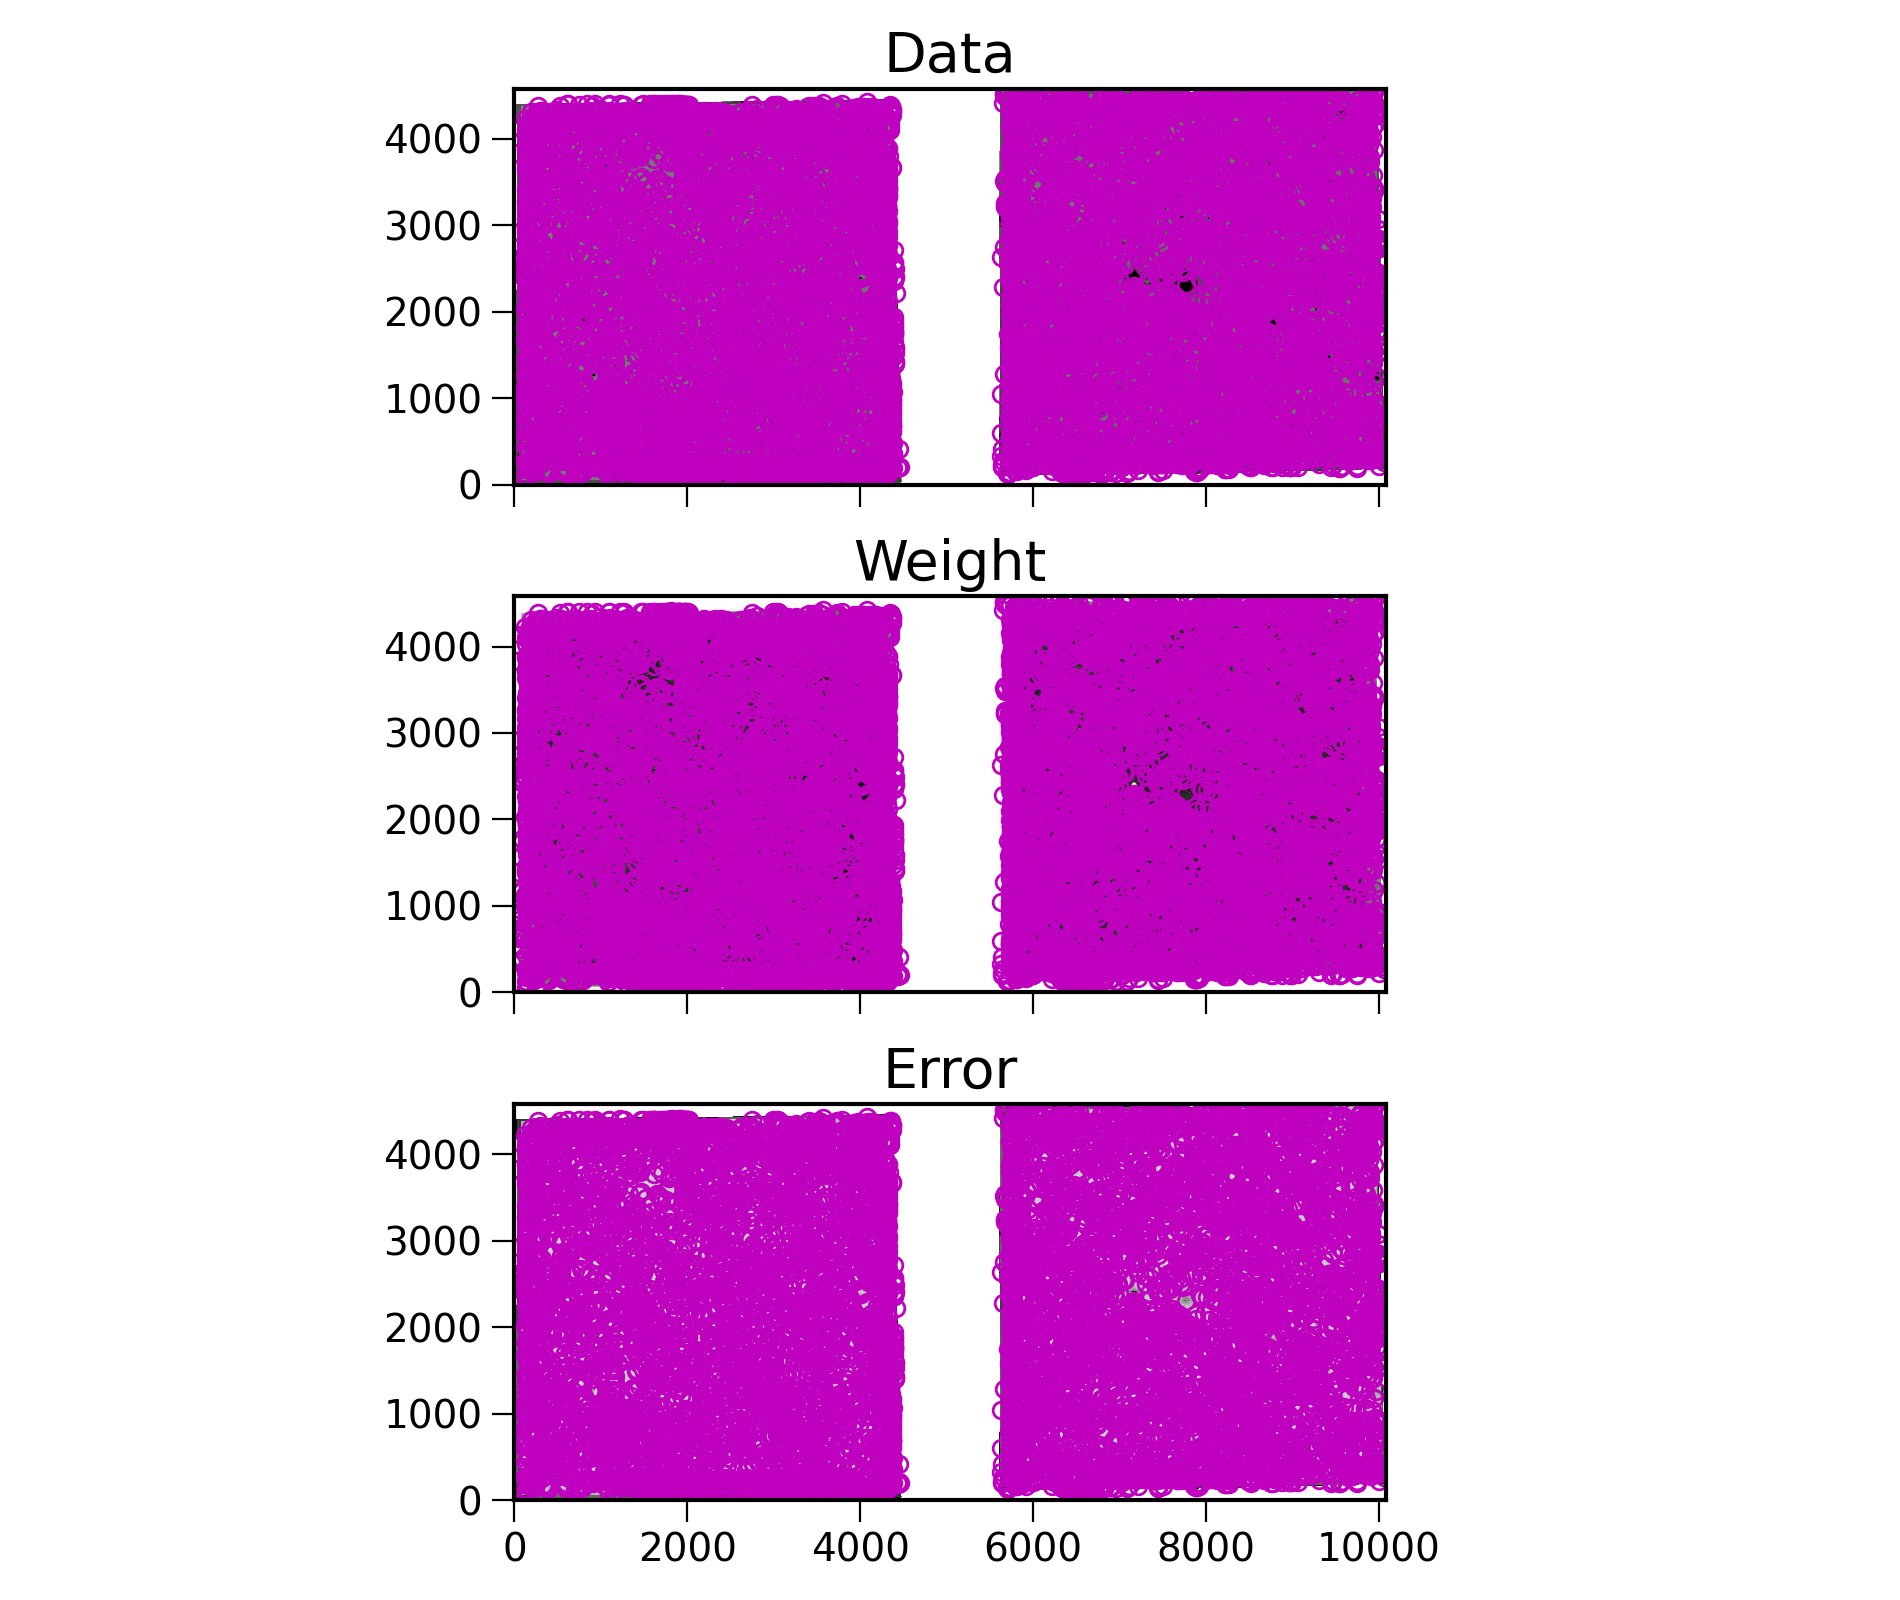

In [56]:
fig, ax = plt.subplots(3, 1, figsize=(9.5, 8), sharex=True, sharey=True)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
ax[0].set_title('Data')
ax[0].imshow(data_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

ax[1].set_title('Weight')
norm = simple_norm(weight_total, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[1].imshow(weight_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

ax[2].set_title('Error')
norm = simple_norm(error_total, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[2].imshow(error_total, origin='lower', norm=norm, interpolation='none', cmap='Greys')

for i in range(3):
    ax[i].plot(source_table['x'], source_table['y'], 'mo', mfc='None')

## Segmentation Map

<IPython.core.display.Javascript object>


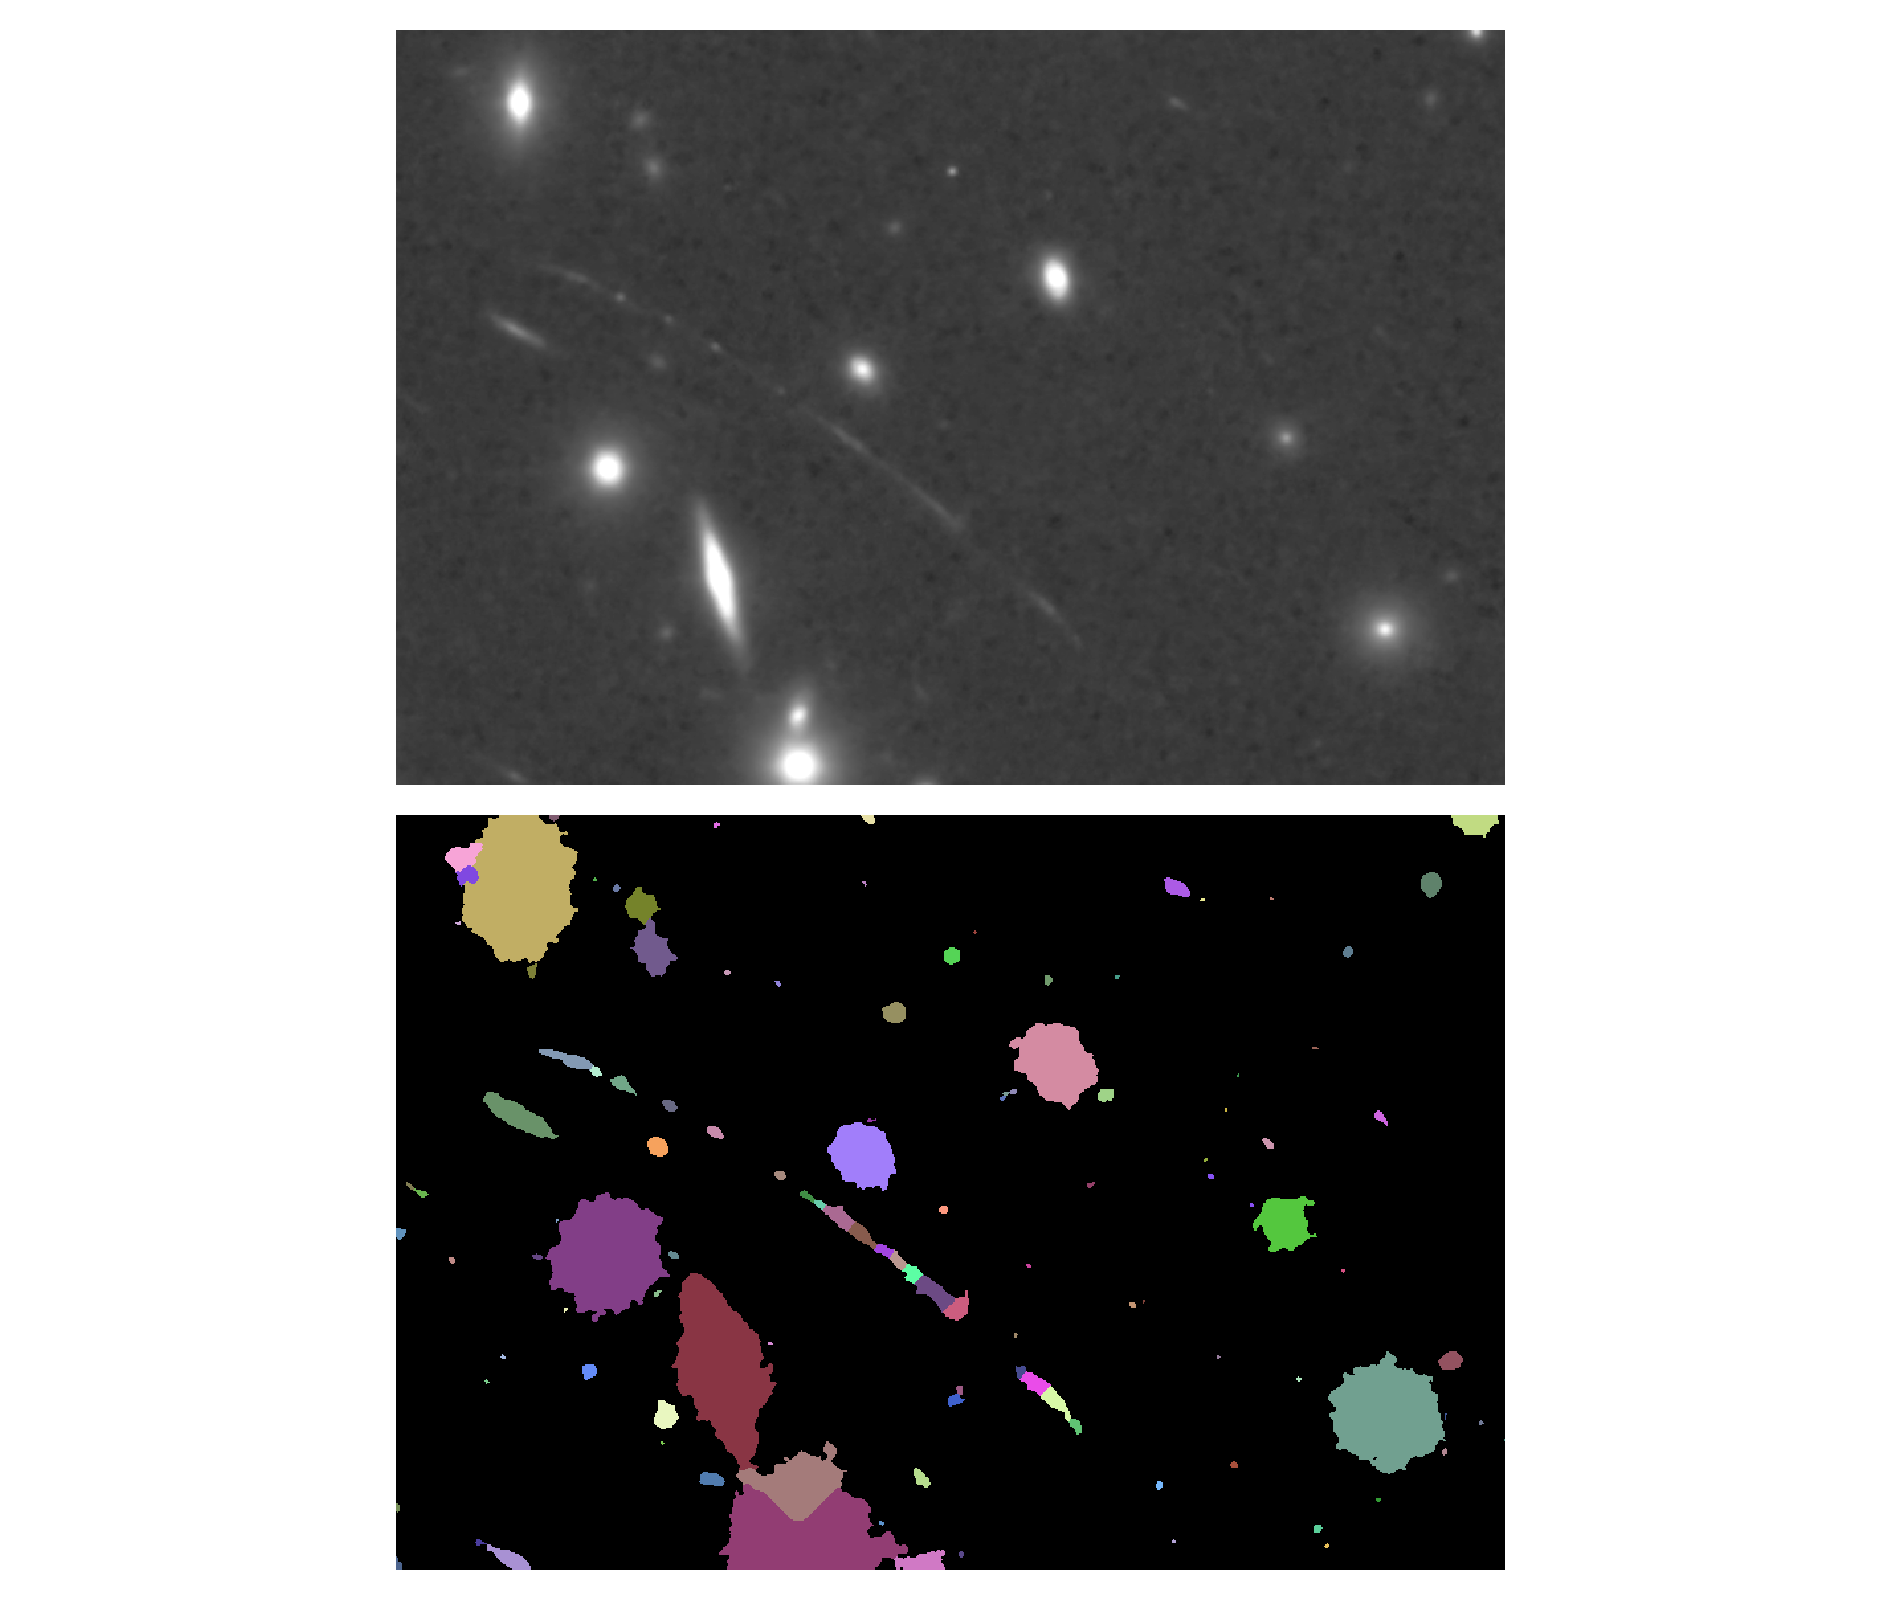

In [57]:
#fig, ax = plt.subplots(1, 2, figsize=(9.5,5), sharex=True, sharey=True)
fig, ax = plt.subplots(2, 1, figsize=(9.5, 8), sharex=True, sharey=True)

norm = simple_norm(detection_catalog.data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0].imshow(detection_catalog.data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
#ax[0].plot(source_table['x'], source_table['y'], 'mo', mfc='None')

cmap = detection_catalog.segm_deblend.make_cmap(seed=123)
ax[1].imshow(detection_catalog.segm_deblend, origin='lower', interpolation='none', cmap=cmap)

for ix in range(2):
    ax[ix].axis('off')

## Multiband photometry using isophotal apertures defined in detection image
(Similar to running SourceExtractor in double-image mode)  
(No PSF corrections just yet)

In [58]:
for filt in filters:
    filter_catalog = Photutils_Catalog(filt)
    filter_catalog.measure_background_map()
    filter_catalog.segm_deblend = detection_catalog.segm_deblend
    filter_catalog.measure_source_properties(properties=output_properties[:-2])  # kron can cause error and don't need it
    
    source_table[filt+'_flux']    = filter_catalog.catalog_table['segment_flux']
    source_table[filt+'_fluxerr'] = filter_catalog.catalog_table['segment_fluxerr']

    source_table[filt+'_mag']     = filter_catalog.catalog_table['segment_flux']
    source_table[filt+'_magerr']  = filter_catalog.catalog_table['segment_magerr']

Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


../images/pipeline/whl0137_nircam_f090w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/catalog.py:2083: RuntimeWarning: invalid value encountered in double_scalars
  gini.append(np.sum(kernel) / normalization)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   

../images/pipeline/whl0137_nircam_f115w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/catalog.py:2083: RuntimeWarning: invalid value encountered in double_scalars
  gini.append(np.sum(kernel) / normalization)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   

../images/pipeline/whl0137_nircam_f150w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/photutils/segmentation/catalog.py:2083: RuntimeWarning: invalid value encountered in double_scalars
  gini.append(np.sum(kernel) / normalization)
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   

../images/pipeline/whl0137_nircam_f200w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


../images/pipeline/whl0137_nircam_f277w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


../images/pipeline/whl0137_nircam_f356w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


../images/pipeline/whl0137_nircam_f410m_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


../images/pipeline/whl0137_nircam_f444w_sci.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Aperture corrections: isophotal to total (Kron aperture) fluxes

In [59]:
total_flux_table = deepcopy(source_table) # copy to new table, which will include total magnitude corrections

reference_flux_auto = total_flux_table['kron_flux']    # Kron total flux estimate
reference_flux_iso  = total_flux_table['segment_flux'] # flux in isophotal aperture defined by detection segment
kron_flux_corrections = reference_flux_auto / reference_flux_iso
total_flux_table['total_flux_cor'] = kron_flux_corrections

for filt in filters:
    total_flux_table[filt+'_flux']    *= kron_flux_corrections
    total_flux_table[filt+'_fluxerr'] *= kron_flux_corrections
    #total_flux_table[filt+'_mag'] = total_flux_table[filt+'_flux'].to(u.ABmag)  # doesn't handle non-detections
    total_flux_table[filt+'_mag'] = fluxes2mags(total_flux_table[filt+'_flux'], total_flux_table[filt+'_fluxerr'])[0]
    # magnitude uncertainty magerr stays the same

## Flux uncertainties w/ correlated noise

In [60]:
# LW images have correlated pixels resulting in underestimate of uncertainties
# Casertano et al. (2000)
# http://www.ifa.hawaii.edu/~rgal/science/sextractor_notes.html
# flux_err_correct ~ flux_err_initial / sqrt(F_A)
s = scale_drizzle = 0.5  # 0.03" output / 0.06" input pixels
p = pixfrac = 1  # ?? well, 1 gives largest inflation
# and should probably inflate more due to PSF convolution
sqrt_F_A = (s/p) * (1 - (s / (3*p)))
print(sqrt_F_A)

for i, filt in enumerate(filters):
    if wavelengths[i] > 2.4 * u.um:
        total_flux_table[filt+'_fluxerr'] /= sqrt_F_A

0.4166666666666667


## Reformat output catalog for readability (optional)

In [61]:
isophotal_table = deepcopy(total_flux_table) # copy to new table, which will include PSF-corrections

old_columns = list(isophotal_table.columns)

# Reorder columns
i = old_columns.index('segment_flux')
j = old_columns.index(filters[0]+'_flux')
columns = old_columns[:i] # detection catalog (except source_sum & kron_flux)
columns += old_columns[-1:]  # total_flux_cor
columns += old_columns[j:-1] # photometry in all filters
        
isophotal_table = isophotal_table[columns]

for column in columns:
    isophotal_table[column].info.format = '.4f'

isophotal_table['ra'].info.format  = '11.7f'
isophotal_table['dec'].info.format = ' 11.7f'

isophotal_table['id'].info.format = 'd'
isophotal_table['area'].info.format = '.0f'  # 'd' raises error : incompatible with units (pix2)

## Isophotal Photometry without PSF corrections complete

We recommend proceeding with PSF corrections to photometry in the Long Wavelength Channel. But if you are interested, you may save the catalog now.

In [62]:
if 0:
    isophotal_table.write(field+'_isophotal_photometry.ecsv', overwrite=True)
    isophotal_table.write(field+'_isophotal_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
    #isophotal_table

# PSF magnitude corrections

Color corrections are perfomed as described here:
https://www.stsci.edu/~dcoe/ColorPro/color

Note this is different from one common approach, which is to degrade every image to the broadest PSF.

Photometry is only corrected in Long Wavelength images > 2.4 microns. The F200W detection image is convolved (blurred) to the PSF of each Long Wavelength image. Then we correct colors based on the magnitudes lost in that aperture:

* PSF_magnitude_corrections = detection_image_magnitudes - blurred_detection_image_magnitudes

In practice, we actually correct the fluxes:

* PSF_flux_corrections = detection_image_fluxes / blurred_detection_image_fluxes

## Load PSFs

NIRCam PSF files available via:  
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/NIRCam_PSFs/

...were extracted from tar files available on JDox:  
https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions#NIRCamPointSpreadFunctions-SimulatedNIRCamPSFs  
PSFs_SW_filters (short wavelength channel): https://stsci.box.com/s/s2lepxr9086gq4sogr3kwftp54n1c5vl  
PSFs_LW_filters (long wavelength channel): https://stsci.box.com/s/gzl7blxb1k3p4n66gs7jvt7xorfrotyb  

Each FITS file contains:  
– hdu[0]: a 4x oversampled PSF  
– hdu[1]: PSF at detector pixel scale (0.031" and 0.063" in the short and long wavelength channels, respectively)  
This notebook will use the latter: PSF at detector pixel scale. We find no advantage to the former for this notebook.

In [71]:
PSF_inputs = {}
PSF_images = {}

detector_pixel_scales = {'SW': 0.031, 'LW': 0.063}

#input_file_url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/'
#PSF_directory = os.path.join(input_file_url, 'NIRCam_PSFs')
# missing F480M

PSF_directory1 = os.path.join(home, 'NIRCam/photometry/PSFmatched/')
#ny_resize = 0  # make them all the same size: the size of the first one measured
ny_crop = 0  # make them all the same size: the size of the first one measured
# Need cropped to same size to calculate convolution kernels

for i, filt in enumerate(filters):
    lam = wavelengths[i]
    if lam < 2.4 * u.um:
        channel = 'SW'  # Short Wavelength Channel < 2.4 microns
    else:
        channel = 'LW'  # Long Wavelength Channel > 2.4 microns
    
    PSF_directory = os.path.join(PSF_directory1, 'NIRCam_PSFs_'+channel)

    # Load PSF
    PSF_file = 'PSF_%scen_G5V_fov299px_ISIM41.fits' % filt
    # PSF_file = os.path.join('NIRCam_PSFs_' + channel, PSF_file)
    PSF_file = os.path.join(PSF_directory, PSF_file)

    print(PSF_file)
    PSF_hdu = fits.open(PSF_file)
    PSF_inputs[filt] = data = PSF_hdu[1].data  # extension [1] is at pixel scale (not oversampled)
    ny, nx = data.shape
    
    # Resize from detector pixel scale to image pixel scale (e.g., 0.02" / pix)
    detector_pixel_scale = detector_pixel_scales[channel]
    #if not ny_resize:  # set size once and use it for all filters
    ny_resize = ny * detector_pixel_scale / image_pixel_scale  # Assume square PSF (ny = nx)
    ny_resize = np.round(ny_resize)
    ny_resize = int((ny_resize // 2) * 2 + 1)  # Make it an odd number of pixels to ensure PSF is centered
    
    ny_crop = ny_crop or ny_resize
        
    PSF_pixel_scale = ny_resize / ny * image_pixel_scale    
    PSF_image = resize_psf(PSF_inputs[filt], PSF_pixel_scale, image_pixel_scale)  # Resize PSF here
    #r = (ny_resize - ny) // 2
    r = (ny_resize - ny_crop) // 2
    if r > 0:  # new size bigger than original
        PSF_image = PSF_image[r:-r, r:-r]  # Trim to same size as input PSFs
    PSF_images[filt] = PSF_image
    # Note PSF is no longer normalized but will be later in convolution step
    print(filt, ny, ny_resize, PSF_image.shape, PSF_pixel_scale, np.sum(PSF_images[filt]))

/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_SW/PSF_f090wcen_G5V_fov299px_ISIM41.fits
f090w 299 297 (297, 297) 0.031022566799056166 0.9950602781679592
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_SW/PSF_f115wcen_G5V_fov299px_ISIM41.fits
f115w 299 297 (297, 297) 0.031022566799056166 0.9937784033157577
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_SW/PSF_f150wcen_G5V_fov299px_ISIM41.fits
f150w 299 297 (297, 297) 0.031022566799056166 0.9921959723769461
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_SW/PSF_f200wcen_G5V_fov299px_ISIM41.fits
f200w 299 297 (297, 297) 0.031022566799056166 0.9902607478503291
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_LW/PSF_f277wcen_G5V_fov299px_ISIM41.fits
f277w 299 603 (297, 297) 0.06298521137990191 0.9908759319828477
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_PSFs_LW/PSF_f356wcen_G5V_fov299px_ISIM41.fits
f356w 299 603 (297, 297) 0.06298521137990191 0.9889446596974291
/Users/dcoe/NIRCam/photometry/PSFmatched/NIRCam_

# PSF Matching

https://photutils.readthedocs.io/en/stable/psf_matching.html

## Determine PSF convolution kernels

performed below using Photutils  

an alternative is to download kernels directly from 
https://www.astro.princeton.edu/~draine/Kernels/Kernels_JWST/  
created using the technique from [Aniano+2011](https://ui.adsabs.harvard.edu/abs/2011PASP..123.1218A/abstract)

In [72]:
PSF_kernels = {}
reference_filter = 'f200w'
reference_PSF = PSF_images[reference_filter]
i_reference = filters.index(reference_filter)
window = CosineBellWindow(alpha=1)
for filt in filters[i_reference+1:]:  # only for longer wavelength filters
    PSF_kernels[filt] = create_matching_kernel(reference_PSF, PSF_images[filt], window=window)

In [73]:
# Check convolved PSFs (optional)

PSFs_convolved = {}
for i, filt in enumerate(filters):
    if wavelengths[i] > 2.4 * u.um:
        PSF_data   = PSF_images[filt]
        PSF_kernel = PSF_kernels[filt]
        print(filt, PSF_data.shape, PSF_kernel.shape)
        PSF_convolved = convolve_fft(PSF_data, PSF_kernel)
        PSFs_convolved[filt] = PSF_convolved

f277w (297, 297) (297, 297)
f356w (297, 297) (297, 297)
f410m (297, 297) (297, 297)
f444w (297, 297) (297, 297)


<IPython.core.display.Javascript object>


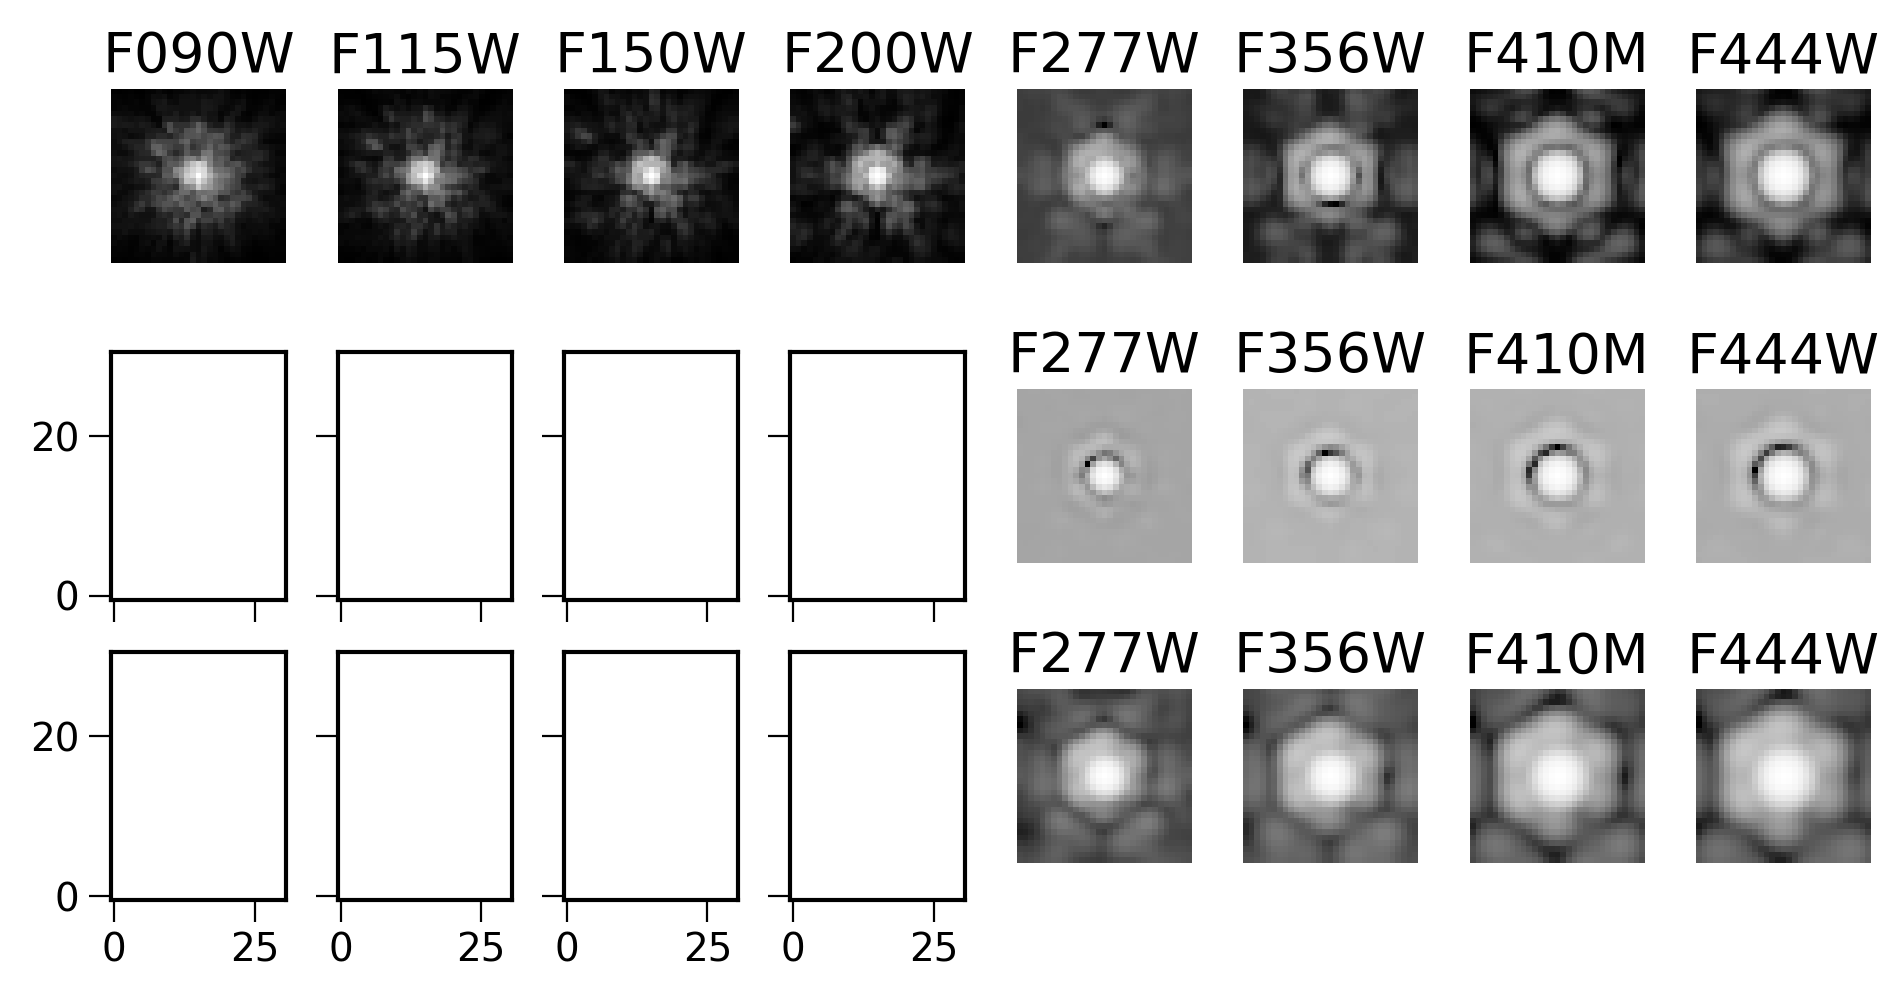

In [74]:
# Show PSFs (optional)

fig, ax = plt.subplots(3, len(filters), figsize=(9.5, 5), sharex=True, sharey=True)

r = 15  # PSF will be shown out to radius r (pixels)
for i, filt in enumerate(filters):
    PSF_data = PSF_images[filt]
    ny, nx = PSF_data.shape
    yc = ny // 2
    xc = nx // 2
    stamp = PSF_data[yc-r:yc+r+1, xc-r:xc+r+1]
    norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
    ax[0,i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
    ax[0,i].set_title(filt.upper())
    ax[0,i].axis('off')
    
    if wavelengths[i] > 2.4 * u.um:
        PSF_kernel = PSF_kernels[filt]
        stamp = PSF_kernel[yc-r:yc+r+1, xc-r:xc+r+1]
        norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
        ax[1,i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
        ax[1,i].set_title(filt.upper())
        ax[1,i].axis('off')    
        
        PSF_convolved = PSFs_convolved[filt]
        stamp = PSF_convolved[yc-r:yc+r+1, xc-r:xc+r+1]
        norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
        ax[2,i].imshow(stamp, cmap='Greys_r', norm=norm, origin='lower')
        ax[2,i].set_title(filt.upper())
        ax[2,i].axis('off')

In [75]:
reference_image_hdu = fits.open(image_files[reference_filter])
reference_image_data = reference_image_hdu[idata].data[:]

for output_filter in filters[i_reference+1:]:
    output_image = '%s_convolved_%s_to_%s.fits' % (field, reference_filter, output_filter)
    if os.path.exists(output_image):
        print(output_image, 'EXISTS')
    else:
        print(output_filter + '...')
        PSF_kernel = PSF_kernels[output_filter][yc-r:yc+r+1, xc-r:xc+r+1]
        # convolve_fft may be faster than convolve for larger images / kernels
        convolved_image = convolve_fft(reference_image_data, PSF_kernel, normalize_kernel=True)
        reference_image_hdu[idata].data = convolved_image
        print('SAVING %s' % output_image)
        reference_image_hdu = reference_image_hdu[:3]  # only save extensions 0 (header) and 1 ('SCI') and 2 ('ERR')
        # 'ERR' isn't blurred, but keep it to get this file through the analysis
        reference_image_hdu.writeto(output_image)

f277w...
SAVING whl0137_convolved_f200w_to_f277w.fits
f356w...
SAVING whl0137_convolved_f200w_to_f356w.fits
f410m...
SAVING whl0137_convolved_f200w_to_f410m.fits
f444w...
SAVING whl0137_convolved_f200w_to_f444w.fits


## Multiband photometry in convolved images

In [76]:
# Measure and save the fluxes in each blurry image
blurry_catalog = QTable()

for blurry_filter in filters[i_reference+1:]:
    image_file = '%s_convolved_%s_to_%s.fits' % (field, reference_filter, blurry_filter)
    filter_catalog = Photutils_Catalog(blurry_filter, image_file=image_file)
    filter_catalog.measure_background_map()

    # Measure photometry in this filter for objects detected in detected image
    # segmentation map will define isophotal apertures
    filter_catalog.segm_deblend = detection_catalog.segm_deblend
    filter_catalog.measure_source_properties()

    # Convert measured fluxes to fluxes in nJy
    filter_table = filter_catalog.catalog.to_table()
    blurry_catalog[blurry_filter+'_flux'] = filter_catalog.catalog_table['segment_flux']

Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


whl0137_convolved_f200w_to_f277w.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


whl0137_convolved_f200w_to_f356w.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


whl0137_convolved_f200w_to_f410m.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Set DATE-AVG to '2022-07-30T17:35:35.699' from MJD-AVG.
Set DATE-END to '2022-07-30T17:55:27.482' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.031277 from OBSGEO-[XYZ].
Set OBSGEO-H to 1704809781.143 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


whl0137_convolved_f200w_to_f444w.fits
4581 x 10076 pixels = 143.071" x 314.688" (0.03" / pixel)


/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## PSF magnitude corrections

https://www.stsci.edu/~dcoe/ColorPro/color

In [77]:
PSF_corrected_table = deepcopy(isophotal_table)

reference_fluxes = PSF_corrected_table[reference_filter+'_flux']  # det_flux_auto

for filt in filters[i_reference+1:]:
    # Convert isophotal fluxes to total fluxes
    blurry_total_fluxes = blurry_catalog[filt+'_flux'] * kron_flux_corrections
    PSF_flux_corrections = reference_fluxes / blurry_total_fluxes
    PSF_corrected_table[filt+'_flux']    *= PSF_flux_corrections
    PSF_corrected_table[filt+'_fluxerr'] *= PSF_flux_corrections
    # PSF_corrected_table[filt+'_mag'] = PSF_corrected_fluxes.to(u.ABmag)  # doesn't handle non-detections
    PSF_corrected_table[filt+'_mag'], PSF_corrected_table[filt+'_magerr'] = \
        fluxes2mags(PSF_corrected_table[filt+'_flux'], PSF_corrected_table[filt+'_fluxerr'])
    PSF_corrected_table[filt+'_PSF_flux_cor'] = PSF_flux_corrections    

In [78]:
# Flux in uJy (should have done that above)
for filt in filters:
    PSF_corrected_table[filt+'_flux']    = PSF_corrected_table[filt+'_flux'].to(u.uJy)
    PSF_corrected_table[filt+'_fluxerr'] = PSF_corrected_table[filt+'_fluxerr'].to(u.uJy)    

In [79]:
PSF_corrected_table.write(field+'_photometry.ecsv', overwrite=True)
PSF_corrected_table.write(field+'_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [80]:
PSF_corrected_table.write(field+'_photometry.csv', overwrite=True)  # for EAZY with flux in uJy

In [81]:
field+'_photometry.cat'

'whl0137_photometry.cat'

In [82]:
PSF_corrected_table

<QTable length=10064>
  id      x         y     ... f410m_PSF_flux_cor f444w_PSF_flux_cor
                          ...                                      
int64  float64   float64  ...      float64            float64      
----- --------- --------- ... ------------------ ------------------
   50 2461.4978   18.5001 ...                nan                nan
   52 1759.7999   20.4992 ...                nan                nan
   53  143.1000   22.6283 ...                nan                nan
   54 2241.6723   24.8653 ...                nan                nan
   55 3003.7344   22.7344 ...                nan                nan
   56 1836.5991   21.7982 ...                nan                nan
   57 3017.7992   21.6002 ...                nan                nan
   58 3106.8735   21.8715 ...                nan                nan
   59 1863.3336   23.3329 ...                nan                nan
   60 3025.4989   23.3306 ...                nan                nan
   61 3180.4609   25.0719 ...                nan                nan
   62 3401.9161   27.9399 ...                nan                nan
   63 2261.8898   24.4453 ...                nan                nan
   64 2149.8230   28.0017 ...                nan                nan
   65 2970.9570   29.5844 ...                nan                nan
   66 3192.5558   27.9998 ...                nan                nan
   67 2848.9986   28.0001 ...                nan                nan
   68 2879.8987   28.4007 ...                nan                nan
  ...       ...       ... ...                ...                ...
10583 5675.7031 4490.2540 ...                nan                nan
10584 5670.7641 4493.4646 ...                nan                nan
10585 6460.9259 4508.3709 ...                nan                nan
10587 5844.2740 4514.2435 ...                nan                nan
10588 5864.3532 4517.2617 ...                nan                nan
10594 7858.9945 4506.4987 ...             4.9292             5.0876
10595 7864.4087 4511.2259 ...                nan                nan
10596 7082.1793 4508.1735 ...                nan                nan
10597 7093.8114 4508.5418 ...                nan                nan
10598 5663.9994 4509.2490 ...                nan                nan
10599 5664.8871 4513.3313 ...                nan                nan
10600 5668.5168 4516.7298 ...                nan                nan
10604 9105.2416 4539.0081 ...                nan                nan
10605 9110.6156 4536.6963 ...                nan                nan
10607 9135.2745 4540.0229 ...                nan                nan
10608 9126.5242 4543.7242 ...                nan                nan
10609 9143.1609 4544.6380 ...                nan                nan
10610 9184.3619 4543.7358 ...                nan                nan

# Signal-to-Noise vs. magnitude

In [83]:
output_catalog = PSF_corrected_table

In [84]:
def between(lo, x, hi):
    return (lo < x) * (x < hi)

<IPython.core.display.Javascript object>


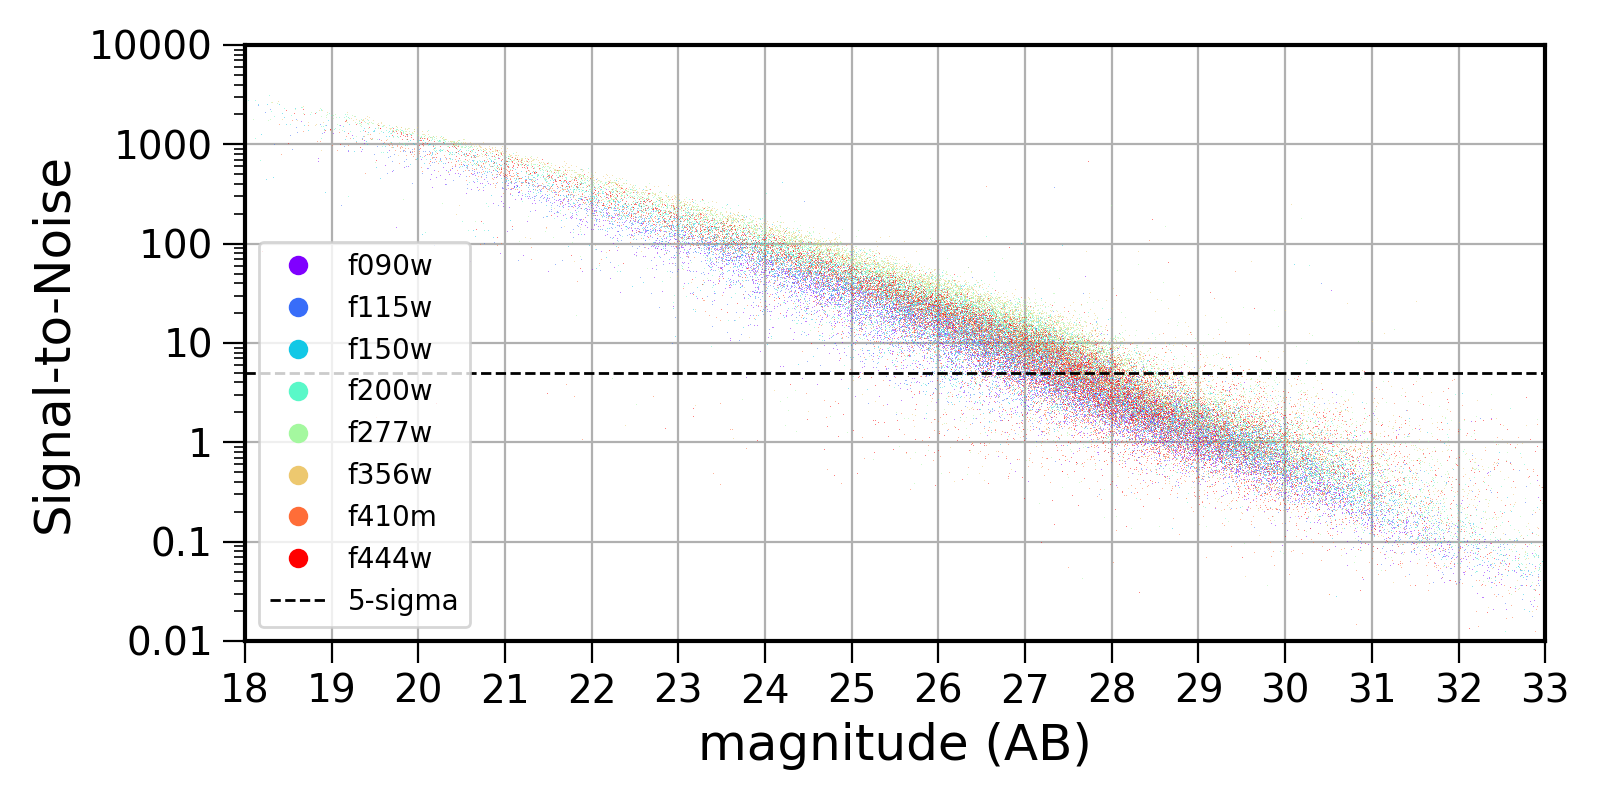

/Users/dcoe/miniconda3/envs/jwstdata/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [85]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(8,4))

cmap = matplotlib.cm.get_cmap("rainbow")
x_min = 0.0  # bluest filter will be purple
#x_min = 0.1  # bluest filter will be blue

#for filt in filters:
#filts2plot = 'f200w f356w'.split()
filts2plot = filters[:]
for i, filt in enumerate(filts2plot):
    flux = output_catalog[filt+'_flux']
    fluxerr = output_catalog[filt+'_fluxerr']
    SNR = flux / fluxerr
    #mag = flux.to(u.ABmag)
    mag = output_catalog[filt+'_mag']
    good = between(0, mag.value, 90)
    mag    = mag[good]
    SNR = SNR[good]
    plot_color = cmap(i / (len(filters) - 1) * (1 - x_min) + x_min)
    plt.plot([40], [1], 'o', color=plot_color, label=filt)  # for legend
    plt.plot(mag, SNR, ',', color=plot_color, alpha=0.5)

plt.axhline(5, c='k', ls='--', lw=1, label='5-sigma')

#plt.xlim(28,34)
#plt.ylim(1,15)

plt.xlim(18,33)
plt.xlabel('magnitude (AB)')
plt.ylabel('Signal-to-Noise')
plt.semilogy()
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.ylim(0.01, 10000)
plt.grid()

#secax = ax.secondary_xaxis('top', functions=(AB2nJy, nJy2AB))
#secax.set_xlabel('Flux (nJy)')

plt.legend();
plt.savefig('SNR_vs_mag.png') # _%s_%s.png' % tuple(filts2plot))

<IPython.core.display.Javascript object>


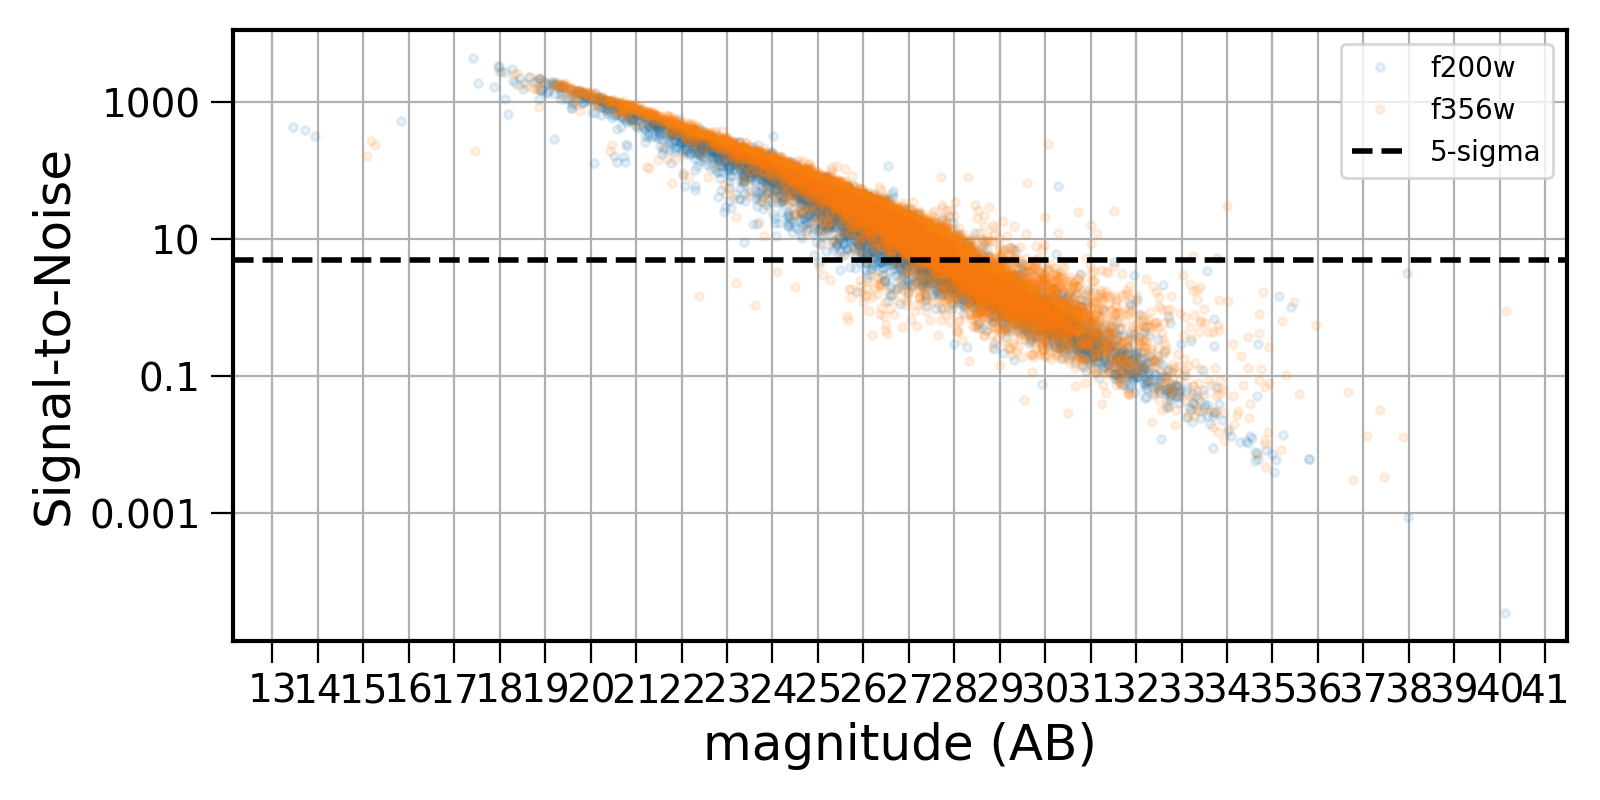

In [86]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(8,4))

#for filt in filters:
filts2plot = 'f200w f356w'.split()
for filt in filts2plot:
    flux = output_catalog[filt+'_flux']
    fluxerr = output_catalog[filt+'_fluxerr']
    SNR = flux / fluxerr
    #mag = flux.to(u.ABmag)
    mag = output_catalog[filt+'_mag']
    good = between(0, mag.value, 90)
    mag    = mag[good]
    SNR = SNR[good]
    plt.plot(mag, SNR, '.', alpha=0.1, label=filt)

plt.axhline(5, c='k', ls='--', label='5-sigma')

#plt.xlim(28,34)
#plt.ylim(1,15)

plt.xlabel('magnitude (AB)')
plt.ylabel('Signal-to-Noise')
plt.semilogy()
plt.yscale('log')
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.grid()

#secax = ax.secondary_xaxis('top', functions=(AB2nJy, nJy2AB))
#secax.set_xlabel('Flux (nJy)')

plt.legend();
plt.savefig('SNR_vs_mag_%s_%s.png' % tuple(filts2plot))

<IPython.core.display.Javascript object>


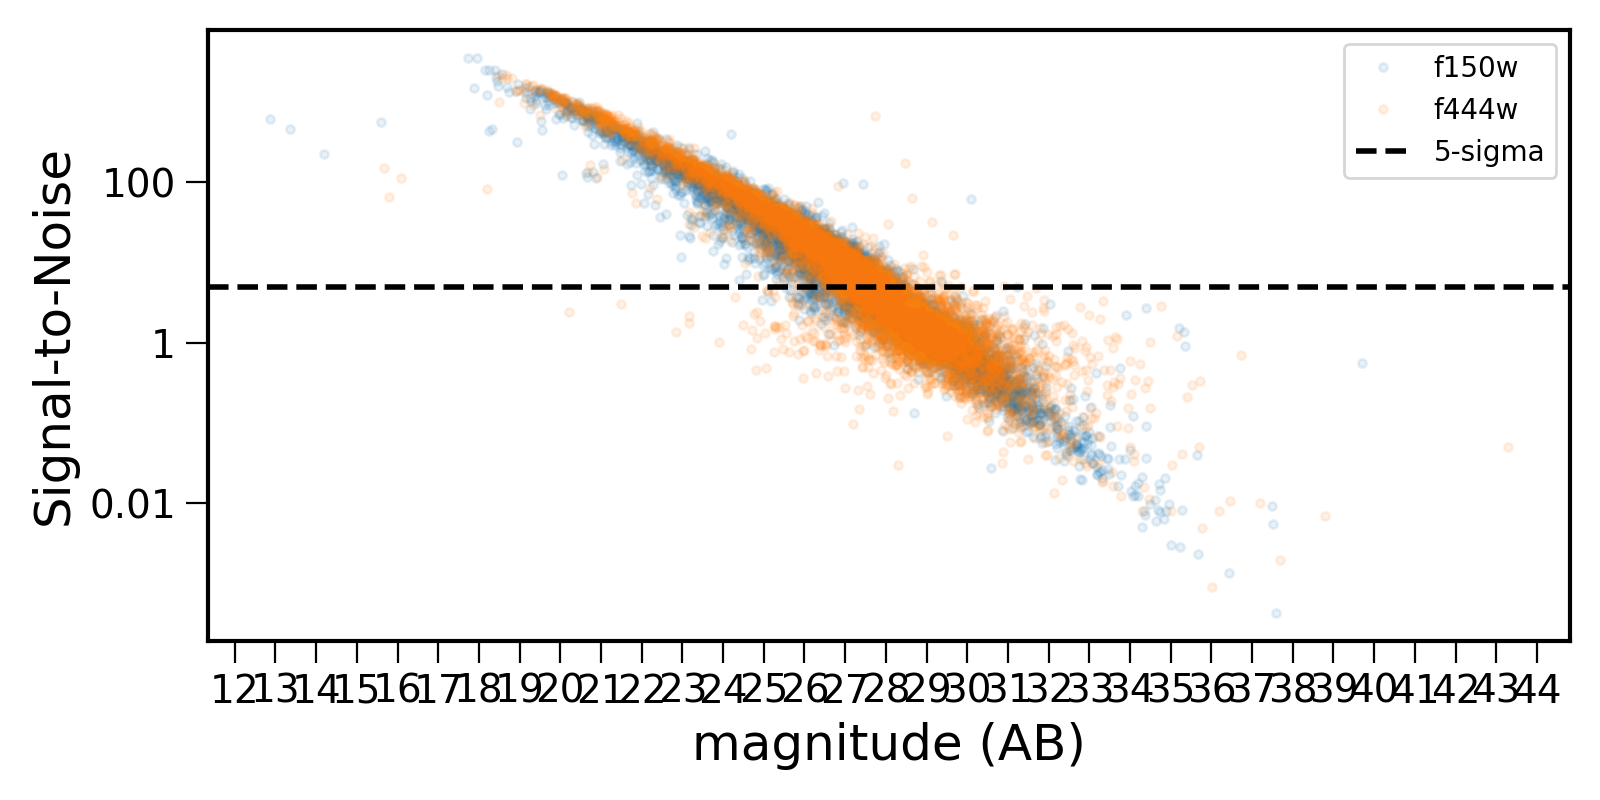

In [87]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(8,4))

#for filt in filters:
filts2plot = 'f150w f444w'.split()
for filt in filts2plot:
    flux = output_catalog[filt+'_flux']
    fluxerr = output_catalog[filt+'_fluxerr']
    SNR = flux / fluxerr
    #mag = flux.to(u.ABmag)
    mag = output_catalog[filt+'_mag']
    good = between(0, mag.value, 90)
    mag    = mag[good]
    SNR = SNR[good]
    plt.plot(mag, SNR, '.', alpha=0.1, label=filt)

plt.axhline(5, c='k', ls='--', label='5-sigma')

#plt.xlim(28,34)
#plt.ylim(1,15)

plt.xlabel('magnitude (AB)')
plt.ylabel('Signal-to-Noise')
plt.semilogy()
plt.yscale('log')
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(1))

#secax = ax.secondary_xaxis('top', functions=(AB2nJy, nJy2AB))
#secax.set_xlabel('Flux (nJy)')

plt.legend();
plt.savefig('SNR_vs_mag_%s_%s.png' % tuple(filts2plot))

<IPython.core.display.Javascript object>


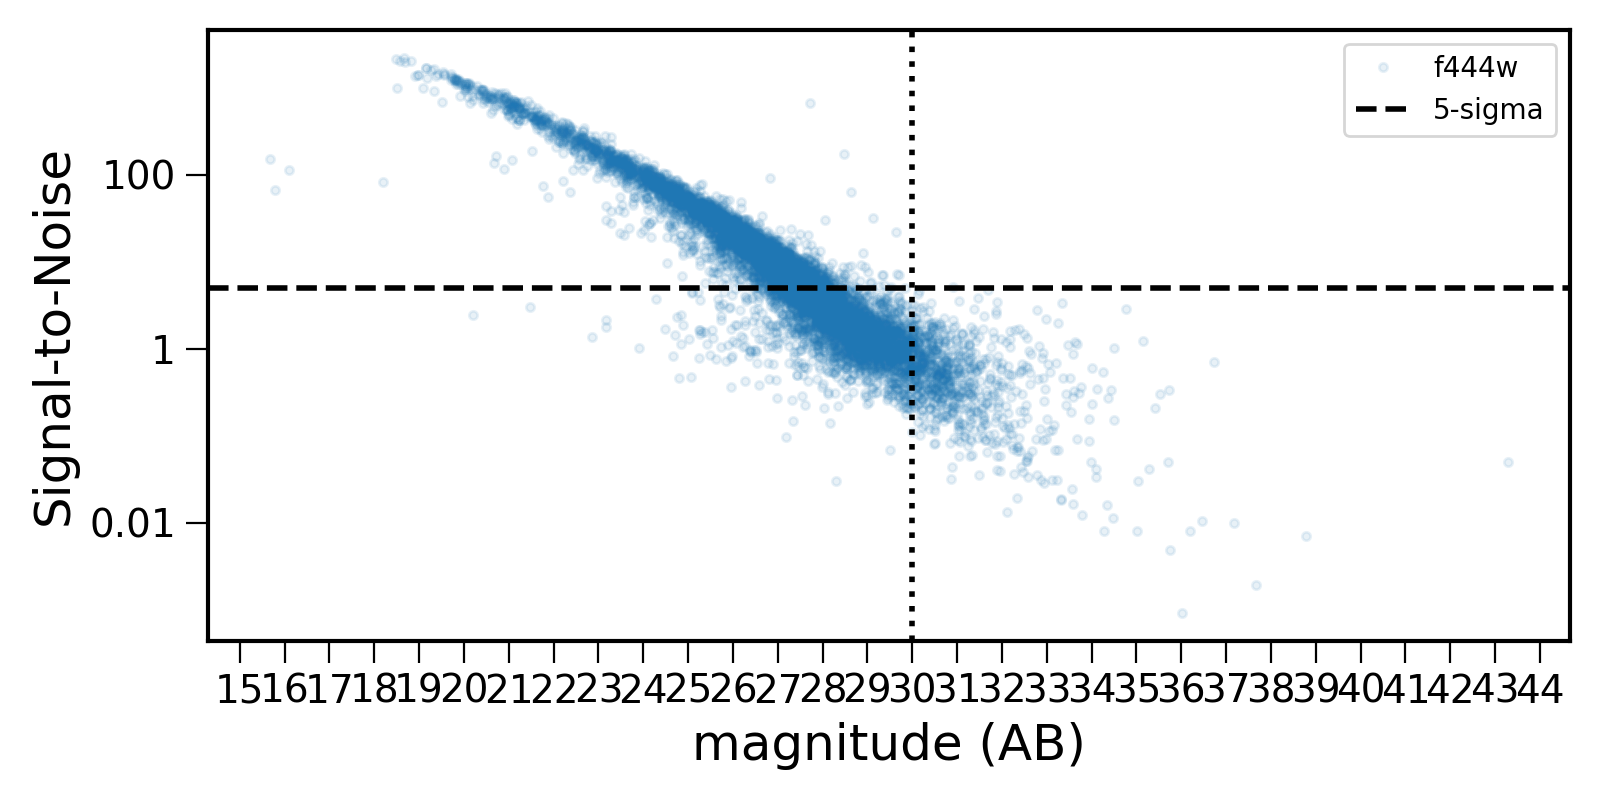

In [88]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

fig, ax = plt.subplots(figsize=(8,4))

filt = 'f444w'
flux = output_catalog[filt+'_flux']
fluxerr = output_catalog[filt+'_fluxerr']
SNR = flux / fluxerr
#mag = flux.to(u.ABmag)
mag = output_catalog[filt+'_mag']
good = between(0, mag.value, 90)
mag    = mag[good]
SNR = SNR[good]
plt.plot(mag, SNR, '.', alpha=0.1, label=filt)

plt.axhline(5, c='k', ls='--', label='5-sigma')
plt.axvline(30, c='k', ls=':')

#plt.xlim(28,34)
#plt.ylim(1,15)

plt.xlabel('magnitude (AB)')
plt.ylabel('Signal-to-Noise')
plt.semilogy()
plt.yscale('log')
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(1))

#secax = ax.secondary_xaxis('top', functions=(AB2nJy, nJy2AB))
#secax.set_xlabel('Flux (nJy)')

plt.legend();
plt.savefig('SNR_vs_mag_%s.png' % filt)